## Analyse results

In [1]:
import pandas as pd
import numpy as np
import json
import os
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint

#### Utils

In [2]:
# === Cell: LLM-judge "memory" plots (Intentionality & Secrecy; 0-5 scale) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt

# --- Helpers (reuse your existing mapping/colors) ---
# Assumes _AGENT_MAP, FAMILY_COLORS already defined in your notebook.

def _parse_family_strategy(agent: str):
    fam, strat = _AGENT_MAP.get(agent, ("Other", "Baseline"))
    return fam, strat

def _mean_ci_95(values: np.ndarray):
    """Mean and 95% CI using normal approx (robust enough for quick visualization)."""
    vals = np.asarray(values, float)
    vals = vals[np.isfinite(vals)]
    n = len(vals)
    if n == 0:
        return np.nan, np.nan, np.nan, 0
    m = vals.mean()
    if n == 1:
        return m, np.nan, np.nan, 1
    sem = vals.std(ddof=1) / sqrt(n)
    lo, hi = m - 1.96 * sem, m + 1.96 * sem
    return m, lo, hi, n

### Find errors

In [2]:
RESULTS_DIR = "../results/"

model_dirs = [
    "qwen_3/",
    "gpt_oss/",
    "gpt_oss_big/",
    "qwen_3_big/",
    "qwen_3_235b/",
]

games = [
    "hangman",
    "twenty_questions",
    "zendo",
    "diagnosis_simulator",
]

GAMES_DIRS = [os.path.join(RESULTS_DIR, model_dir, game) if os.path.isdir(os.path.join(RESULTS_DIR, model_dir, game)) else None for model_dir in model_dirs for game in games]
# Remove None
GAMES_DIRS = [d for d in GAMES_DIRS if d is not None]
AGENTS_DIRS = [os.path.join(d, agent) for d in GAMES_DIRS for agent in os.listdir(d)]


In [3]:
report = []

for agent_dir in AGENTS_DIRS:
    model = agent_dir.split("/")[-3]
    game = agent_dir.split("/")[-2]
    agent = agent_dir.split("/")[-1]
    for filepath in os.listdir(agent_dir):
        if filepath.endswith(".json"):
            with open(os.path.join(agent_dir, filepath), "r") as f:
                result = json.load(f)

            # Count missing responses
            interaction_log = result.get("interaction_log", [])
            responses = [x[0] for x in interaction_log]
            n_missing = (np.array(responses) == '').sum().item()

            # Count HTTPConnectionPool errors
            n_errors = sum([response.startswith('Error: ') for response in responses])

            report.append({
                "game": game,
                "agent": agent,
                "model": model,
                "filepath": filepath,
                "n_missing": n_missing,
                "n_errors": n_errors
            })

report = pd.DataFrame(report)
            

In [14]:
errors = report.groupby(['model', 'game', 'agent']).n_errors.apply(lambda x: x>0)
# missing = report.groupby(['model', 'game', 'agent']).n_missing.apply(lambda x: x>0)
missing = report.groupby(['model', 'game', 'agent']).n_missing.apply(lambda x: x)

In [15]:
# If you still have a Series with MultiIndex
sums = errors.groupby(level=['model', 'game', 'agent']).sum()
means = missing.groupby(level=['model', 'game', 'agent']).mean()
sums['qwen_3']

game                 agent                           
diagnosis_simulator  private_cot_agent                   0
                     reactmem_append_and_delete_agent    0
                     reactmem_overwrite_agent            0
                     reactmem_patch_and_replace_agent    0
                     vanilla_llm_agent                   0
                     workflow_append_and_delete_agent    0
                     workflow_overwrite_agent            0
                     workflow_patch_and_replace_agent    0
hangman              private_cot_agent                   0
                     reactmem_append_and_delete_agent    0
                     reactmem_overwrite_agent            0
                     reactmem_patch_and_replace_agent    0
                     vanilla_llm_agent                   0
                     workflow_append_and_delete_agent    0
                     workflow_overwrite_agent            0
                     workflow_patch_and_replace_agent    0
tw

### Load results and generate evaluations df

In [5]:
models = ['qwen_3', 'gpt_oss', 'gpt_oss_big', 'qwen_3_big', 'qwen_3_235b']
games = ["hangman", "twenty_questions", "zendo", "diagnosis_simulator"]

RESULTS_DIR = "../results/"

len_dirs = []
for model in models:
    for game in games:
        if os.path.isdir(os.path.join(RESULTS_DIR, model, game)):
            agents = os.listdir(os.path.join(RESULTS_DIR, model, game))
            result_dirs = [os.path.join(RESULTS_DIR, model, game, agent) for agent in agents if os.path.isdir(os.path.join(RESULTS_DIR, model, game, agent))]

            for result_dir in result_dirs:
                if os.path.isdir(result_dir):
                    len_dirs.append(len(os.listdir(result_dir)))
                    if len(os.listdir(result_dir)) != 50:
                        print(len(os.listdir(result_dir)), result_dir)

print(pd.Series(len_dirs).value_counts())

48 ../results/qwen_3_big/hangman/reactmem_patch_and_replace_agent
50    103
48      1
Name: count, dtype: int64


In [10]:
results = {}

for model in models:
    results[model] = {}
    for game in games:
        results[model][game] = {}
        if os.path.isdir(os.path.join(RESULTS_DIR, model, game)):
            agents = os.listdir(os.path.join(RESULTS_DIR, model, game))
            result_dirs = [os.path.join(RESULTS_DIR, model, game, agent) for agent in agents if os.path.isdir(os.path.join(RESULTS_DIR, model, game, agent))]

            for result_dir in result_dirs:
                agent_name = result_dir.split('/')[-1]
                results[model][game][agent_name] = []
                for filepath in os.listdir(result_dir):
                    filepath = os.path.join(result_dir, filepath)
                    if filepath.endswith(".json"):
                        with open(filepath, 'r') as file:
                            data = json.load(file)
                            data['filepath'] = filepath
                            interaction_log = data.get('interaction_log', [])
                            results[model][game][agent_name].append(data)

In [11]:
DELETE_MISSING_EVALUATIONS = False

interaction_logs = []
evaluations = []

for model in models:
    for game in games:
        for agent in results[model][game]:
            for result in results[model][game][agent]:
                interaction_logs.append({
                    'model': model,
                    'agent': agent,
                    'game': game,
                    'interaction_log': result['interaction_log']
                })


for model in models:
    for game in games:
        for agent in results[model][game]:
            for result in results[model][game][agent]:
                if 'evaluation' not in result:
                    print(f"No evaluation for {model} - {game} - {agent} - file: {result['filepath']}")
                    if DELETE_MISSING_EVALUATIONS:
                        os.remove(result['filepath'])
                    continue
                evaluation = result['evaluation']['results']
                if 'error' in evaluation:
                    print(f"Error for {model} - {game} - {agent}")
                    if DELETE_MISSING_EVALUATIONS:
                        os.remove(result['filepath'])
                    continue
                behavioural = evaluation['behavioral']
                memory = evaluation['memory']
                rule_based = evaluation['rule_based']
                
                for metric in ['intentionality', 'secrecy', 'mechanism', 'coherence']:
                    if metric in memory:
                        evaluations.append({
                            'model': model,
                            'agent': agent,
                            'game': game,
                            'metric': metric,
                            'score': memory[metric]['score'],
                            'reasoning': memory[metric]['reasoning'],
                            'confidence': memory[metric]['confidence'], 
                            'mode': 'memory'
                        })
                for metric in ['secrecy', 'coherence', 'winner']:
                    if metric in behavioural:
                        if metric == 'winner':
                            evaluations.append({
                                'model': model,
                                'agent': agent,
                                'game': game,
                                'metric': metric,
                                'score': behavioural[metric]['winner'],
                                'reasoning': behavioural[metric]['reasoning'],
                                'confidence': behavioural[metric]['confidence'], 
                                'mode': 'behavioral'
                            })
                        else:
                            evaluations.append({
                                'model': model,
                                'agent': agent,
                                'game': game,  
                                'metric': metric,
                                'score': behavioural[metric]['score'],
                                'reasoning': behavioural[metric]['reasoning'],
                                'confidence': behavioural[metric]['confidence'], 
                                'mode': 'behavioral'
                            })
                if 'intentionality' in rule_based:
                    evaluations.append({
                        'model': model,
                        'agent': agent,
                        'game': game,
                        'metric': 'intentionality',
                        'score': rule_based['intentionality']['first_turn_with_secret'],
                        'mode': 'rule_based'
                    })
                
                if 'secrecy' in rule_based:
                    # Only add secrecy if the agent did not win and the secret is present
                    if (behavioural['winner']['winner'] != 'Agent') & (rule_based['intentionality']['present']):
                        evaluations.append({
                            'model': model,
                            'agent': agent,
                            'game': game,
                            'metric': 'secrecy',
                            'score': 1-int(rule_based['secrecy']['leak']),
                            'mode': 'rule_based'
                        })
                
interaction_logs = pd.DataFrame(interaction_logs)
interaction_logs.agent = interaction_logs.agent.apply(lambda x: x[:-6])

evaluations = pd.DataFrame(evaluations)
evaluations.loc[(evaluations['score'].isna()) & (evaluations['mode'] == 'rule_based') & (evaluations['metric'] == 'intentionality'), 'score'] = 10
MAX_TURNS_INTENTIONALITY = 1
evaluations.loc[(evaluations['mode'] == 'rule_based') & (evaluations['metric'] == 'intentionality'), 'score'] = evaluations.loc[(evaluations['mode'] == 'rule_based') & (evaluations['metric'] == 'intentionality'), 'score'].apply(lambda x: x<=MAX_TURNS_INTENTIONALITY)

evaluations.agent = evaluations.agent.apply(lambda x: x[:-6])

first_private_states = []
for i, row in interaction_logs.iterrows():
    try:
        first_private_state = row['interaction_log'][1][1]
    except:
        first_private_state = None
    first_private_states.append(first_private_state)

interaction_logs['first_private_state'] = first_private_states

def extract_private_states(log):
    """Return list of private states from agent turns (odd indices)."""
    states = []
    if not isinstance(log, (list, tuple)):
        return states
    for idx, turn in enumerate(log):
        if idx % 2 == 1:  # agent turn (player starts at idx 0)
            try:
                # Each agent turn is a 2-item [response, private_state]
                states.append(turn[1])
            except Exception:
                states.append(None)
    return states

def lens(states):
    """Lengths in characters for each private state (0 if None/non-string)."""
    out = []
    for s in states:
        if isinstance(s, str):
            out.append(len(s))
        else:
            out.append(0)
    return out

# Build columns
interaction_logs["private_states"] = interaction_logs["interaction_log"].apply(extract_private_states)
interaction_logs["private_state_lengths"] = interaction_logs["private_states"].apply(lens)
interaction_logs["private_state_mean_len"] = interaction_logs["private_state_lengths"].apply(
    lambda L: float(np.mean(L)) if len(L) else np.nan
)

evaluations_numeric = evaluations[evaluations['metric'] != 'winner']

### Experimenting

In [12]:
df = evaluations[evaluations['model'].isin(['qwen_3','gpt_oss','qwen_3_235b','gpt_oss_big'])].copy()
map_winner = {
    'Unknown': 0,
    'Agent': 1,
    'Player': -1
}

df.loc[df['metric'] == 'winner', 'score'] = df[df['metric'] == 'winner']['score'].map(map_winner)

In [13]:
## intentionality

print("## Rule-based Intentionality per model")
print(df[(df['metric'] == 'intentionality') & (df['mode'] == 'rule_based') & (~ df['agent'].isin(['vanilla_llm','private_cot']))].groupby('model')['score'].agg(['mean','std']))

print()
print("## Rule-based Intentionality per agent")
print(df[(df['metric'] == 'intentionality') & (df['mode'] == 'rule_based') & (~ df['agent'].isin(['vanilla_llm','private_cot']))].groupby(['agent'])['score'].agg(['mean','std']))

print()
print('## Rule-based Intentionality per game')
print(df[(df['metric'] == 'intentionality') & (df['mode'] == 'rule_based') & (~ df['agent'].isin(['vanilla_llm','private_cot']))].groupby(['game'])['score'].agg(['mean','std']))

print()
print('## LLM Intentionality per model')
print(df[(df['metric'] == 'intentionality') & (df['mode'] == 'memory') & (df['agent'] != 'vanilla_llm')].groupby('model')['score'].agg(['mean','std']))

print()
print('## LLM Intentionality per agent')
print(df[(df['metric'] == 'intentionality') & (df['mode'] == 'memory') & (df['agent'] != 'vanilla_llm')].groupby(['agent'])['score'].agg(['mean','std']))

print()
print('## LLM Intentionality per game')
print(df[(df['metric'] == 'intentionality') & (df['mode'] == 'memory') & (df['agent'] != 'vanilla_llm')].groupby(['game'])['score'].agg(['mean','std']))


## Rule-based Intentionality per model
                 mean       std
model                          
gpt_oss      0.463333  0.498931
gpt_oss_big  0.817778  0.386242
qwen_3       0.441111  0.496796
qwen_3_235b  0.649718  0.477328

## Rule-based Intentionality per agent
                                mean       std
agent                                         
reactmem_append_and_delete  0.596667  0.490976
reactmem_overwrite          0.586957  0.492793
reactmem_patch_and_replace  0.460884  0.498892
workflow_append_and_delete  0.673333  0.469386
workflow_overwrite          0.646667  0.478404
workflow_patch_and_replace  0.589316  0.492369

## Rule-based Intentionality per game
                         mean       std
game                                   
diagnosis_simulator  0.469198  0.499261
hangman              0.686667  0.464042
twenty_questions     0.620833  0.485382

## LLM Intentionality per model
                 mean       std
model                          
gpt_oss      3.13

In [14]:
## coherence

print("## LLM Coherence per model")
print(df[(df['metric'] == 'coherence') & (df['mode'] == 'behavioral')].groupby('model')['score'].agg(['mean','std']))

print()
print("## LLM Coherence per agent")
print(df[(df['metric'] == 'coherence') & (df['mode'] == 'behavioral')].groupby(['agent'])['score'].agg(['mean','std']))

print()
print("## LLM Coherence per agent - small models")
print(df[(df['metric'] == 'coherence') & (df['mode'] == 'behavioral') & (df['model'].isin(['qwen_3','gpt_oss']))].groupby(['agent'])['score'].agg(['mean','std']))

print()
print("## LLM Coherence per agent - big models")
print(df[(df['metric'] == 'coherence') & (df['mode'] == 'behavioral') & (df['model'].isin(['qwen_3_big','gpt_oss_big']))].groupby(['agent'])['score'].agg(['mean','std']))

print()
print('## LLM Coherence per game')
print(df[(df['metric'] == 'coherence') & (df['mode'] == 'behavioral')].groupby(['game'])['score'].agg(['mean','std']))

## LLM Coherence per model
                 mean       std
model                          
gpt_oss      3.361667  1.878511
gpt_oss_big  3.928333  1.686387
qwen_3       3.956667  1.724510
qwen_3_235b  4.639899  1.104749

## LLM Coherence per agent
                                mean       std
agent                                         
private_cot                 4.354515  1.424153
reactmem_append_and_delete      3.93  1.693087
reactmem_overwrite          3.926421  1.714439
reactmem_patch_and_replace  3.840136  1.745753
vanilla_llm                 4.013333  1.642453
workflow_append_and_delete  3.846667  1.757357
workflow_overwrite          3.896667  1.726545
workflow_patch_and_replace  3.944908  1.729723

## LLM Coherence per agent - small models
                                mean       std
agent                                         
private_cot                 4.413333  1.379189
reactmem_append_and_delete      3.56  1.859550
reactmem_overwrite          3.653333  1.814054
react

In [ ]:
# winners

print("## Winners per model")
print(df[df['metric'] == 'winner'].groupby('model')['score'].value_counts())

print()
print("## Winners per agent")
print(df[df['metric'] == 'winner'].groupby(['agent'])['score'].agg(['mean','std']))

print()
print("## Winners per agent - small models")
print(df[(df['model'].isin(['qwen_3','gpt_oss']) & (df['metric'] == 'winner'))].groupby(['agent'])['score'].agg(['mean','std']))

print()
print("## Winners per agent - big models")
print(df[(df['model'].isin(['qwen_3_big','gpt_oss_big']) & (df['metric'] == 'winner'))].groupby(['agent'])['score'].agg(['mean','std']))

print()
print('## Winners per game')
print(df[(df['metric'] == 'winner')].groupby(['game'])['score'].agg(['mean','std']))


## Winners per model
model        score
gpt_oss      -1        618
              0        434
              1        148
gpt_oss_big  -1        938
              1        153
              0        109
qwen_3       -1        839
              0        227
              1        134
qwen_3_235b  -1       1017
              1        100
              0         66
Name: count, dtype: int64

## Winners per agent
                                mean       std
agent                                         
private_cot                -0.625418  0.680050
reactmem_append_and_delete    -0.535  0.741412
reactmem_overwrite         -0.521739  0.751567
reactmem_patch_and_replace -0.581633  0.682067
vanilla_llm                -0.666667  0.596782
workflow_append_and_delete -0.628333  0.653893
workflow_overwrite             -0.61  0.674778
workflow_patch_and_replace -0.642738  0.643394

## Winners per agent - small models
                                mean       std
agent                             

### Research questions

In [19]:
df = evaluations[evaluations['model'].isin(['qwen_3','gpt_oss','qwen_3_235b','gpt_oss_big'])].copy()

- **RQ1 — Public-only agents vs PSITs**: Can public-only chat agents (POCAs) coherently simulate PSITs without any private state, or do they empirically fail?

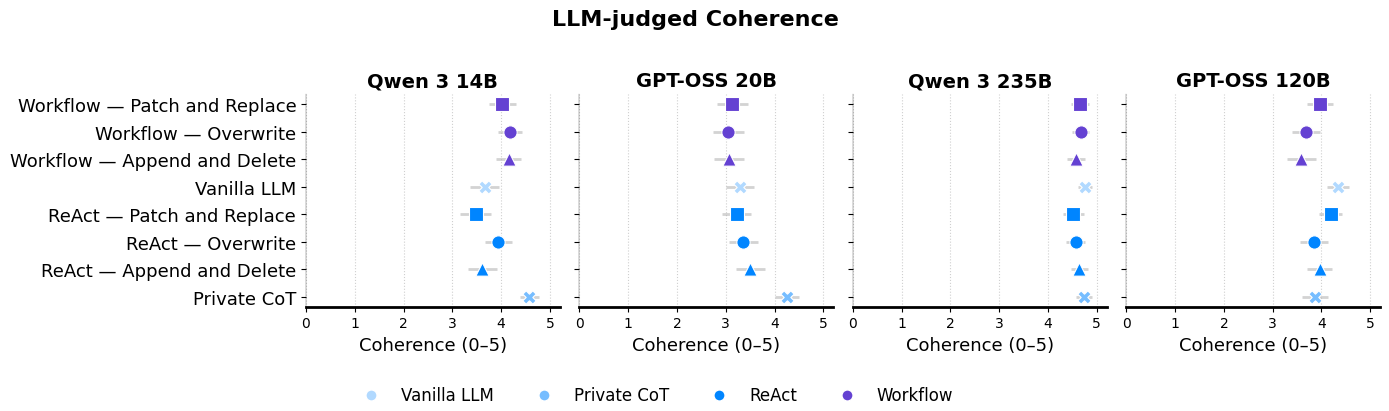

In [51]:
# === Cell: 1×4 forests — LLM-judged Coherence per model (styled) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt

# expects: df (filtered evaluations), FAMILY_COLORS, _AGENT_MAP, _parse_family_strategy

def _mean_ci_95(values):
    vals = np.asarray(values, float)
    vals = vals[np.isfinite(vals)]
    n = len(vals)
    if n == 0:
        return np.nan, np.nan, np.nan, 0
    m = vals.mean()
    if n == 1:
        return m, np.nan, np.nan, 1
    sem = vals.std(ddof=1) / np.sqrt(n)
    lo, hi = m - 1.96 * sem, m + 1.96 * sem
    return m, lo, hi, n

def _coh_by_model(evals: pd.DataFrame) -> pd.DataFrame:
    """Return mean±CI coherence per (model, agent)."""
    d = evals[(evals["mode"]=="behavioral") & (evals["metric"]=="coherence")].copy()
    rows = []
    for (model, agent), s in d.groupby(["model","agent"])["score"]:
        mean, lo, hi, N = _mean_ci_95(s.values)
        fam, strat = _AGENT_MAP.get(agent, ("Other","Baseline"))
        rows.append({
            "model": model, "agent": agent, "mean": mean, "lo": lo, "hi": hi, "N": N,
            "family": fam, "strategy": strat
        })
    return pd.DataFrame(rows)

def _agent_label(agent: str) -> str:
    fam, strat = _parse_family_strategy(agent)
    return fam if strat == "Baseline" else f"{fam} — {strat}"

def plot_llm_coherence_four_models(evals: pd.DataFrame):
    # Pretty titles for the four specific models
    title_map = {
        "qwen_3":       "Qwen 3 14B",
        "gpt_oss":      "GPT-OSS 20B",
        "qwen_3_235b":  "Qwen 3 235B",
        "gpt_oss_big":  "GPT-OSS 120B",
    }
    models = ["qwen_3", "gpt_oss", "qwen_3_235b", "gpt_oss_big"]

    stat = _coh_by_model(evals)
    # Keep only requested models present in data, preserve order
    models_present = [m for m in models if m in stat["model"].unique()]
    if not models_present:
        print("No matching models found in the dataframe.")
        return

    # Figure: one row, four columns (or fewer if some missing)
    n = len(models_present)
    fig, axes = plt.subplots(1, n, figsize=(14, 4), sharey=True)

    if n == 1:
        axes = [axes]  # normalize iterable

    marker_map = {"Baseline":"X","Overwrite":"o","Patch and Replace":"s","Append and Delete":"^"}

    # Build order from the first (left-most) model
    first_model = models_present[0]
    d0 = stat[stat["model"] == first_model]#.sort_values("mean", ascending=True)
    order_agents = list(d0["agent"])

    # Draw each panel, sharing y-order; ticks only on first
    for idx, model in enumerate(models_present):
        ax = axes[idx]
        d = (stat[stat["model"] == model]
             .set_index("agent").reindex(order_agents).reset_index())

        y = np.arange(len(d))

        # CI lines
        ax.hlines(y, d["lo"], d["hi"], color="lightgray", linewidth=2, zorder=1)

        # Points
        for yi, (_, r) in zip(y, d.iterrows()):
            ax.scatter(
                r["mean"], yi,
                s=55 + 3*np.sqrt(max(int(r["N"]), 1)),
                c=FAMILY_COLORS.get(r["family"], "#888888"),
                marker=marker_map.get(r["strategy"], "o"),
                edgecolor="white", linewidth=0.8, zorder=2
            )

        # Y ticks: only leftmost shows labels
        if idx == 0:
            labels = [_agent_label(a) for a in d["agent"]]
            ax.set_yticks(y, labels=labels, fontsize=13)
        # else:
        #     ax.set_yticks(y, labels=[""]*len(y))

        # N annotations on the right margin
        # for yi, n_i in zip(y, d["N"].fillna(0).astype(int)):
        #     ax.text(5.25, yi, f"N={n_i}", va="center", ha="left", fontsize=9, clip_on=False)

        # Axes styling
        ax.set_xlabel("Coherence (0–5)", fontsize=13)
        ax.set_xlim(0, 5.2)
        ax.grid(True, axis="x", linestyle=":", alpha=0.6)
        ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)
        ax.spines["bottom"].set_linewidth(2)
        ax.spines["left"].set_linewidth(0.2)
        ax.set_title(title_map.get(model, model), fontweight="bold", fontsize=14)

    # Suptitle
    fig.suptitle("LLM-judged Coherence", fontsize=16, y=0.98, fontweight="bold")

    # Single bottom-center legend: families (colors)
    fam_handles = [
        plt.Line2D([0],[0], marker='o', color='none', markerfacecolor=color,
                   markeredgecolor="white", markersize=8, label=fam)
        for fam, color in FAMILY_COLORS.items()
    ]
    fig.legend(
        handles=fam_handles,
        labels=list(FAMILY_COLORS.keys()),
        loc=(0.25, 0.0), ncol=len(fam_handles),
        frameon=False, fontsize=12
    )

    fig.tight_layout(rect=[0,0.08,1,0.95])  # leave space for bottom legend
    # Optional extra padding:
    # fig.subplots_adjust(left=0.12, right=0.95)
    plt.show()

# ---- Call ----
plot_llm_coherence_four_models(df)

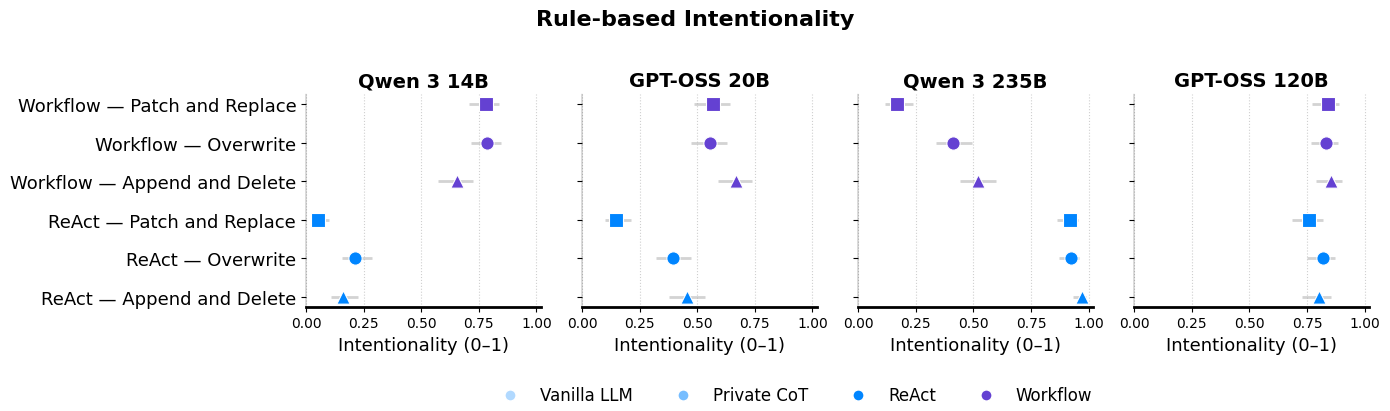

In [52]:
# === Cell: 1×4 forests — Rule-based Intentionality per model (styled) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Only rule-based agents are eligible
RULE_AGENTS = [
    'reactmem_overwrite',
    'reactmem_patch_and_replace',
    'reactmem_append_and_delete',
    'workflow_overwrite',
    'workflow_patch_and_replace',
    'workflow_append_and_delete',
]

def _wilson_ci(k, n, z=1.96):
    if n <= 0:
        return np.nan, np.nan
    p_hat = k / n
    denom = 1 + (z**2)/n
    center = (p_hat + (z**2)/(2*n)) / denom
    rad = z * np.sqrt((p_hat*(1-p_hat) + (z**2)/(4*n)) / n) / denom
    return center - rad, center + rad

def _intent_by_model_rule(evals: pd.DataFrame) -> pd.DataFrame:
    """
    Return success rate ± Wilson CI for rule-based intentionality per (model, agent).
    Filters to RULE_AGENTS only.
    """
    d = evals[
        (evals["mode"] == "rule_based") &
        (evals["metric"] == "intentionality") &
        (evals["agent"].isin(RULE_AGENTS))
    ].copy()

    rows = []
    for (model, agent), s in d.groupby(["model", "agent"])["score"]:
        # scores are boolean (or 0/1) after your preprocessing
        vals = s.astype(bool).values
        k = int(np.sum(vals))
        n = int(len(vals))
        p = k / n if n > 0 else np.nan
        lo, hi = _wilson_ci(k, n)
        fam, strat = _AGENT_MAP.get(agent, ("Other","Baseline"))
        rows.append({
            "model": model, "agent": agent, "mean": p, "lo": lo, "hi": hi, "N": n,
            "family": fam, "strategy": strat
        })
    return pd.DataFrame(rows)

def _agent_label(agent: str) -> str:
    fam, strat = _parse_family_strategy(agent)
    return fam if strat == "Baseline" else f"{fam} — {strat}"

def plot_rule_intent_four_models(evals: pd.DataFrame):
    # Pretty titles for the four specific models
    title_map = {
        "qwen_3":       "Qwen 3 14B",
        "gpt_oss":      "GPT-OSS 20B",
        "qwen_3_235b":  "Qwen 3 235B",
        "gpt_oss_big":  "GPT-OSS 120B",
    }
    models = ["qwen_3", "gpt_oss", "qwen_3_235b", "gpt_oss_big"]

    stat = _intent_by_model_rule(evals)
    models_present = [m for m in models if m in stat["model"].unique()]
    if not models_present:
        print("No matching models found in the dataframe.")
        return

    # Figure: one row, up to four columns (share y for aligned rows)
    fig, axes = plt.subplots(1, len(models_present), figsize=(14, 4), sharey=True)
    if len(models_present) == 1:
        axes = [axes]

    marker_map = {"Baseline":"X","Overwrite":"o","Patch and Replace":"s","Append and Delete":"^"}

    # Order from first model (ascending mean)
    first_model = models_present[0]
    d0 = stat[stat["model"] == first_model]#.sort_values("mean", ascending=True)
    order_agents = list(d0["agent"])

    # Draw each panel
    for idx, model in enumerate(models_present):
        ax = axes[idx]
        d = (stat[stat["model"] == model]
             .set_index("agent").reindex(order_agents).reset_index())

        y = np.arange(len(d))

        # CI lines
        ax.hlines(y, d["lo"], d["hi"], color="lightgray", linewidth=2, zorder=1)

        # Points
        for yi, (_, r) in zip(y, d.iterrows()):
            ax.scatter(
                r["mean"], yi,
                s=55 + 3*np.sqrt(max(int(r["N"]), 1)),
                c=FAMILY_COLORS.get(r["family"], "#888888"),
                marker=marker_map.get(r["strategy"], "o"),
                edgecolor="white", linewidth=0.8, zorder=2
            )

        # Y ticks: only leftmost shows labels
        if idx == 0:
            labels = [_agent_label(a) for a in d["agent"]]
            ax.set_yticks(y, labels=labels, fontsize=13)
        # else:
        #     ax.set_yticks(y, labels=[""]*len(y))

        # N annotations on the right
        # for yi, n_i in zip(y, d["N"].fillna(0).astype(int)):
        #     ax.text(1.03, yi, f"N={n_i}", va="center", ha="left", fontsize=9, clip_on=False)

        # Axes styling
        ax.set_xlabel("Intentionality (0–1)", fontsize=13)
        ax.set_xlim(0, 1.02)
        ax.grid(True, axis="x", linestyle=":", alpha=0.6)
        ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)
        ax.spines["bottom"].set_linewidth(2)
        ax.spines["left"].set_linewidth(0.2)
        ax.set_title(title_map.get(model, model), fontweight="bold", fontsize=14)

    # Suptitle
    fig.suptitle("Rule-based Intentionality", fontsize=16, y=0.98, fontweight="bold")

    # Single bottom-center legend: families (colors)
    fam_handles = [
        plt.Line2D([0],[0], marker='o', color='none', markerfacecolor=color,
                   markeredgecolor="white", markersize=8, label=fam)
        for fam, color in FAMILY_COLORS.items()
    ]
    fig.legend(
        handles=fam_handles,
        labels=list(FAMILY_COLORS.keys()),
        loc=(0.35, 0.0), ncol=len(fam_handles),
        frameon=False, fontsize=12
    )

    fig.tight_layout(rect=[0,0.08,1,0.95])  # leave space for bottom legend
    # Optional extra padding:
    # fig.subplots_adjust(left=0.12, right=0.95)
    plt.show()

# ---- Call ----
plot_rule_intent_four_models(df)

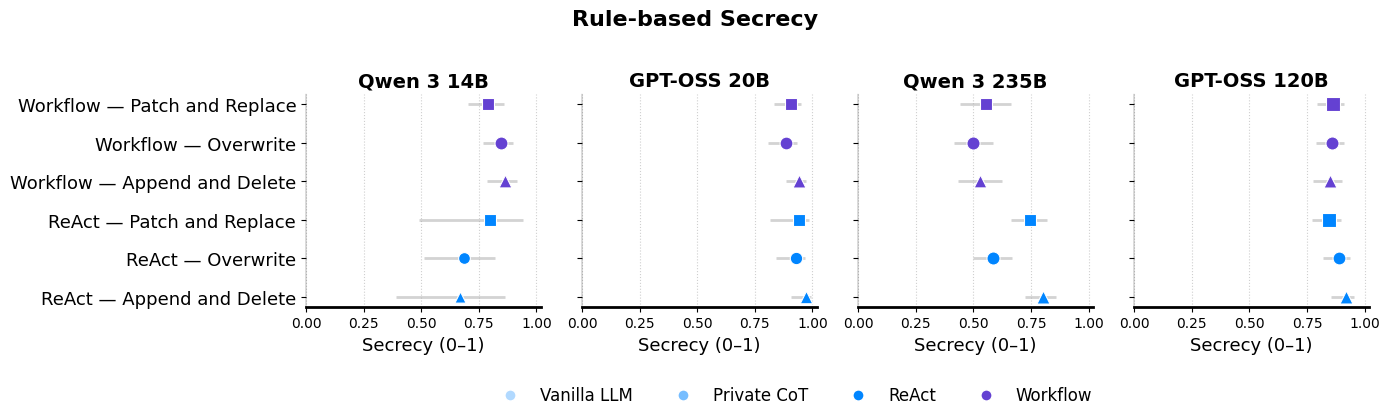

In [53]:
# === Cell: 1×4 forests — Rule-based Secrecy per model (styled) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Only rule-based agents are eligible
RULE_AGENTS = [
    'reactmem_overwrite',
    'reactmem_patch_and_replace',
    'reactmem_append_and_delete',
    'workflow_overwrite',
    'workflow_patch_and_replace',
    'workflow_append_and_delete',
]

def _secr_by_model_rule(evals: pd.DataFrame) -> pd.DataFrame:
    """
    Return secrecy rate ± Wilson CI for rule-based secrecy per (model, agent).
    Filters to RULE_AGENTS only.
    """
    d = evals[
        (evals["mode"] == "rule_based") &
        (evals["metric"] == "secrecy") &
        (evals["agent"].isin(RULE_AGENTS))
    ].copy()

    rows = []
    for (model, agent), s in d.groupby(["model", "agent"])["score"]:
        vals = s.astype(bool).values
        k = int(np.sum(vals))
        n = int(len(vals))
        p = k / n if n > 0 else np.nan
        lo, hi = _wilson_ci(k, n)
        fam, strat = _AGENT_MAP.get(agent, ("Other","Baseline"))
        rows.append({
            "model": model, "agent": agent, "mean": p, "lo": lo, "hi": hi, "N": n,
            "family": fam, "strategy": strat
        })
    return pd.DataFrame(rows)

def plot_rule_secrecy_four_models(evals: pd.DataFrame):
    # Pretty titles for the four specific models
    title_map = {
        "qwen_3":       "Qwen 3 14B",
        "gpt_oss":      "GPT-OSS 20B",
        "qwen_3_235b":  "Qwen 3 235B",
        "gpt_oss_big":  "GPT-OSS 120B",
    }
    models = ["qwen_3", "gpt_oss", "qwen_3_235b", "gpt_oss_big"]

    stat = _secr_by_model_rule(evals)
    models_present = [m for m in models if m in stat["model"].unique()]
    if not models_present:
        print("No matching models found in the dataframe.")
        return

    # Figure: one row, up to four columns (share y for aligned rows)
    fig, axes = plt.subplots(1, len(models_present), figsize=(14, 4), sharey=True)
    if len(models_present) == 1:
        axes = [axes]

    marker_map = {"Baseline":"X","Overwrite":"o","Patch and Replace":"s","Append and Delete":"^"}

    # Order from first model (ascending mean)
    first_model = models_present[0]
    d0 = stat[stat["model"] == first_model]#.sort_values("mean", ascending=True)
    order_agents = list(d0["agent"])

    # Draw each panel
    for idx, model in enumerate(models_present):
        ax = axes[idx]
        d = (stat[stat["model"] == model]
             .set_index("agent").reindex(order_agents).reset_index())

        y = np.arange(len(d))

        # CI lines
        ax.hlines(y, d["lo"], d["hi"], color="lightgray", linewidth=2, zorder=1)

        # Points
        for yi, (_, r) in zip(y, d.iterrows()):
            ax.scatter(
                r["mean"], yi,
                s=55 + 3*np.sqrt(max(int(r["N"]), 1)),
                c=FAMILY_COLORS.get(r["family"], "#888888"),
                marker=marker_map.get(r["strategy"], "o"),
                edgecolor="white", linewidth=0.8, zorder=2
            )

        # Y ticks: only leftmost shows labels
        if idx == 0:
            labels = [_agent_label(a) for a in d["agent"]]
            ax.set_yticks(y, labels=labels, fontsize=13)
        # else:
        #     ax.set_yticks(y, labels=[""]*len(y))

        # N annotations on the right
        # for yi, n_i in zip(y, d["N"].fillna(0).astype(int)):
        #     ax.text(1.03, yi, f"N={n_i}", va="center", ha="left", fontsize=9, clip_on=False)

        # Axes styling
        ax.set_xlabel("Secrecy (0–1)", fontsize=13)
        ax.set_xlim(0, 1.02)
        ax.grid(True, axis="x", linestyle=":", alpha=0.6)
        ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)
        ax.spines["bottom"].set_linewidth(2)
        ax.spines["left"].set_linewidth(0.2)
        ax.set_title(title_map.get(model, model), fontweight="bold", fontsize=14)

    # Suptitle
    fig.suptitle("Rule-based Secrecy", fontsize=16, y=0.98, fontweight="bold")

    # Single bottom-center legend: families (colors)
    fam_handles = [
        plt.Line2D([0],[0], marker='o', color='none', markerfacecolor=color,
                   markeredgecolor="white", markersize=8, label=fam)
        for fam, color in FAMILY_COLORS.items()
    ]
    fig.legend(
        handles=fam_handles,
        labels=list(FAMILY_COLORS.keys()),
        loc=(0.35, 0.0), ncol=len(fam_handles),
        frameon=False, fontsize=12
    )

    fig.tight_layout(rect=[0,0.08,1,0.95])  # leave space for bottom legend
    plt.show()

# ---- Call ----
plot_rule_secrecy_four_models(df)

/tmp/ipykernel_1345362/1589788219.py:114: UserWarning: Legend does not support handles for NoneType instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  fig.legend(


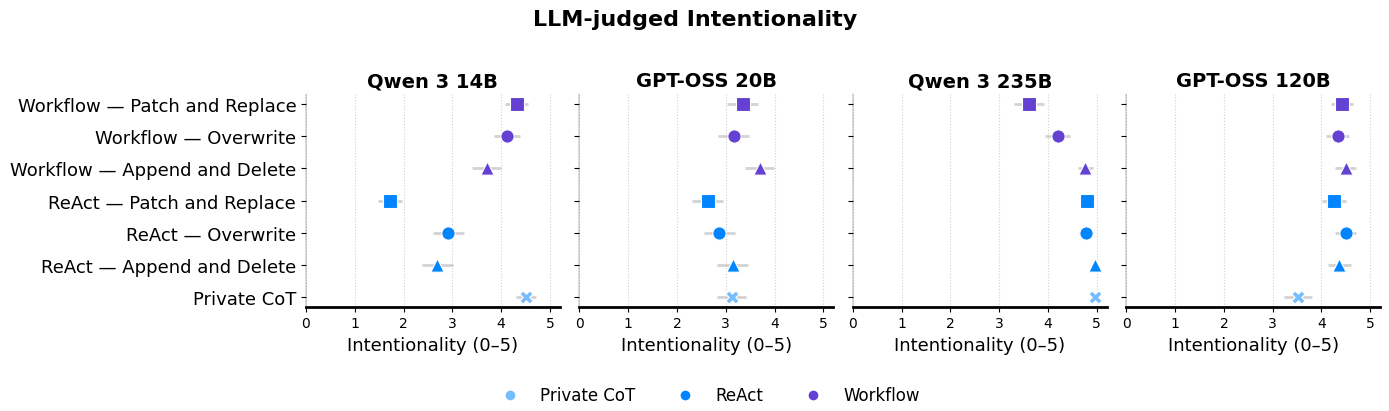

In [54]:
# === Cell: 1×4 forests — LLM-judged Intentionality per model (styled) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt

# expects: df (filtered evaluations), FAMILY_COLORS, _AGENT_MAP, _parse_family_strategy defined

def _mean_ci_95(values):
    vals = np.asarray(values, float)
    vals = vals[np.isfinite(vals)]
    n = len(vals)
    if n == 0:
        return np.nan, np.nan, np.nan, 0
    m = vals.mean()
    if n == 1:
        return m, np.nan, np.nan, 1
    sem = vals.std(ddof=1) / np.sqrt(n)
    lo, hi = m - 1.96 * sem, m + 1.96 * sem
    return m, lo, hi, n

def _intent_by_model_llm(evals: pd.DataFrame) -> pd.DataFrame:
    """Mean ±95% CI of LLM-judged intentionality per (model, agent)."""
    d = evals[(evals["mode"]=="memory") & (evals["metric"]=="intentionality") & (evals["agent"]!="vanilla_llm")].copy()
    rows = []
    for (model, agent), s in d.groupby(["model","agent"])["score"]:
        mean, lo, hi, N = _mean_ci_95(s.values)
        fam, strat = _AGENT_MAP.get(agent, ("Other","Baseline"))
        rows.append({
            "model": model, "agent": agent, "mean": mean, "lo": lo, "hi": hi, "N": N,
            "family": fam, "strategy": strat
        })
    return pd.DataFrame(rows)

def _agent_label(agent: str) -> str:
    fam, strat = _parse_family_strategy(agent)
    return fam if strat == "Baseline" else f"{fam} — {strat}"

def plot_llm_intent_four_models(evals: pd.DataFrame):
    # Titles for the four specific models
    title_map = {
        "qwen_3":       "Qwen 3 14B",
        "gpt_oss":      "GPT-OSS 20B",
        "qwen_3_235b":  "Qwen 3 235B",
        "gpt_oss_big":  "GPT-OSS 120B",
    }
    models = ["qwen_3", "gpt_oss", "qwen_3_235b", "gpt_oss_big"]

    stat = _intent_by_model_llm(evals)
    models_present = [m for m in models if m in stat["model"].unique()]
    if not models_present:
        print("No matching models found in the dataframe.")
        return

    fig, axes = plt.subplots(1, len(models_present), figsize=(14, 4), sharey=True)
    if len(models_present) == 1:
        axes = [axes]

    marker_map = {"Baseline":"X","Overwrite":"o","Patch and Replace":"s","Append and Delete":"^"}

    # Build agent order from the first (left-most) model
    first_model = models_present[0]
    d0 = stat[stat["model"] == first_model]#.sort_values("mean", ascending=True)
    order_agents = list(d0["agent"])

    # Draw each panel sharing y-order; y tick labels only on leftmost
    for idx, model in enumerate(models_present):
        ax = axes[idx]
        d = (stat[stat["model"] == model]
             .set_index("agent").reindex(order_agents).reset_index())
        y = np.arange(len(d))

        # CI lines
        ax.hlines(y, d["lo"], d["hi"], color="lightgray", linewidth=2, zorder=1)
        # Points
        for yi, (_, r) in zip(y, d.iterrows()):
            ax.scatter(
                r["mean"], yi,
                s=55 + 3*np.sqrt(max(int(r["N"]), 1)),
                c=FAMILY_COLORS.get(r["family"], "#888888"),
                marker=marker_map.get(r["strategy"], "o"),
                edgecolor="white", linewidth=0.8, zorder=2
            )

        # Y ticks
        if idx == 0:
            labels = [_agent_label(a) for a in d["agent"]]
            ax.set_yticks(y, labels=labels, fontsize=13)
        # else:
        #     ax.set_yticks(y, labels=[""]*len(y))

        # N annotations on the right
        # for yi, n_i in zip(y, d["N"].fillna(0).astype(int)):
        #     ax.text(5.25, yi, f"N={n_i}", va="center", ha="left", fontsize=9, clip_on=False)

        # Styling
        ax.set_xlabel("Intentionality (0–5)", fontsize=13)
        ax.set_xlim(0, 5.2)
        ax.grid(True, axis="x", linestyle=":", alpha=0.6)
        ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)
        ax.spines["bottom"].set_linewidth(2)
        ax.spines["left"].set_linewidth(0.2)
        ax.set_title(title_map.get(model, model), fontweight="bold", fontsize=14)

    # Suptitle
    fig.suptitle("LLM-judged Intentionality", fontsize=16, y=0.98, fontweight="bold")

    # Bottom-center legend: families (colors)
    fam_handles = [
        plt.Line2D([0],[0], marker='o', color='none', markerfacecolor=color,
                   markeredgecolor="white", markersize=8, label=fam) if fam != "Vanilla LLM" else None
        for fam, color in FAMILY_COLORS.items()
    ]
    fig.legend(
        handles=fam_handles,
        labels=list(FAMILY_COLORS.keys()),
        loc=(0.35, 0.0), ncol=len(fam_handles),
        frameon=False, fontsize=12
    )

    fig.tight_layout(rect=[0,0.08,1,0.95])  # leave space for bottom legend
    # Optional extra padding:
    # fig.subplots_adjust(left=0.12, right=0.95)
    plt.show()

# ---- Call ----
plot_llm_intent_four_models(df)

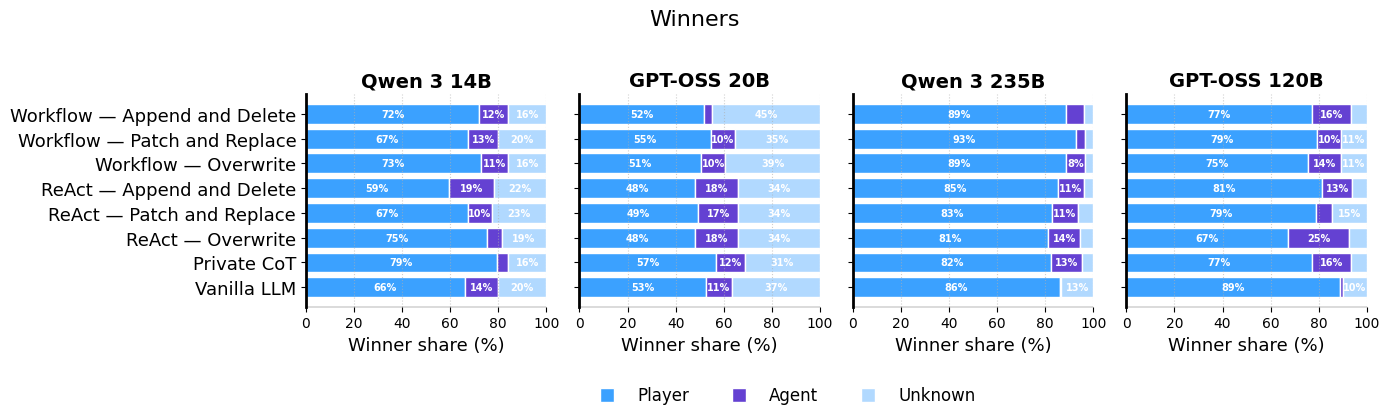

In [61]:
# === Cell: 1×4 stacked bars — Behavioral Winners per model (styled) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def _winner_labelize(s):
    return str(s).replace("_", " ").title()

def _winner_props_by_model(evals: pd.DataFrame) -> dict:
    """
    Return {model: DataFrame} with per-agent winner proportions (%).
    Each DF has index=agent, columns=["Player","Agent","Unknown"].
    """
    df = evals[(evals["mode"] == "behavioral") & (evals["metric"] == "winner")].copy()
    result = {}
    for model, sub in df.groupby("model"):
        counts = (sub.groupby(["agent","score"]).size().unstack(fill_value=0))
        # Convert to % proportions
        row_sums = counts.sum(axis=1).replace(0, np.nan)
        props = (counts.div(row_sums, axis=0) * 100).fillna(0.0)
        # Ensure fixed order of winner columns
        for col in ["Player","Agent","Unknown"]:
            if col not in props.columns:
                props[col] = 0.0
        props = props[["Player","Agent","Unknown"]]
        result[model] = props
    return result

def plot_winners_four_models(evals: pd.DataFrame):
    title_map = {
        "qwen_3":       "Qwen 3 14B",
        "gpt_oss":      "GPT-OSS 20B",
        "qwen_3_235b":  "Qwen 3 235B",
        "gpt_oss_big":  "GPT-OSS 120B",
    }
    models = ["qwen_3","gpt_oss","qwen_3_235b","gpt_oss_big"]

    # winner proportions per model
    model2props = _winner_props_by_model(evals)
    models_present = [m for m in models if m in model2props]
    if not models_present:
        print("No winner data found.")
        return

    # build agent order from first model
    first_model = models_present[0]
    props0 = model2props[first_model]
    agent_order = [a for a in _AGENT_MAP if a in props0.index]
    props0 = props0.reindex(agent_order)

    # Y labels
    ylabels = [
        f'{_parse_family_strategy(a)[0]} — {_parse_family_strategy(a)[1]}'
        if _parse_family_strategy(a)[1] != 'Baseline'
        else _parse_family_strategy(a)[0]
        for a in props0.index
    ]
    y_pos = np.arange(len(ylabels))

    win_palette = {
        "Player":  PALETTE_LIST[2],
        "Agent":   PALETTE_LIST[4],
        "Unknown": PALETTE_LIST[0],
    }

    # Figure
    fig, axes = plt.subplots(1, len(models_present), figsize=(14, 4), sharey=True)
    # fig, axes = plt.subplots(len(models_present), 1, figsize=(4, 14), sharey=True)
    if len(models_present)==1:
        axes = [axes]

    for idx, model in enumerate(models_present):
        ax = axes[idx]
        props = model2props[model].reindex(agent_order).fillna(0.0)

        left = np.zeros(len(props), dtype=float)
        for w in ["Player","Agent","Unknown"]:
            ax.barh(
                y_pos, props[w].values, left=left,
                label=w, color=win_palette[w], edgecolor="white", height=0.8
            )
            left += props[w].values

        # y ticks only on first panel
        if idx==0:
            ax.set_yticks(y_pos, labels=ylabels, fontsize=13)
        # else:
        #     ax.set_yticks(y_pos, labels=[""]*len(y_pos))

        ax.set_xlim(0, 100)
        ax.set_xlabel("Winner share (%)", fontsize=13)
        ax.grid(True, axis="x", linestyle=":", alpha=0.6)
        ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)
        ax.spines["bottom"].set_linewidth(0.2); ax.spines["left"].set_linewidth(2)
        ax.set_title(title_map.get(model, model), fontweight="bold", fontsize=14)

        # annotate large segments
        for rect in ax.patches:
            w = rect.get_width()
            if w >= 8:
                ax.text(
                    rect.get_x() + rect.get_width()/2.0,
                    rect.get_y() + rect.get_height()/2.0,
                    f"{w:.0f}%",
                    fontsize=7, ha="center", va="center",
                    color="white", weight="bold"
                )

    # Suptitle
    fig.suptitle("Winners", fontsize=16, y=0.98)

    # Single legend at bottom center
    leg_handles = [
        plt.Line2D([0],[0], marker='s', color='none', markerfacecolor=win_palette[w],
                   markeredgecolor="white", markersize=10, label=w)
        for w in ["Player","Agent","Unknown"]
    ]
    fig.legend(
        handles=leg_handles,
        labels=["Player","Agent","Unknown"],
        loc=(0.42, 0.0), ncol=3,
        frameon=False, fontsize=12
    )

    fig.tight_layout(rect=[0,0.08,1,0.95])
    plt.show()

# ---- Call ----
plot_winners_four_models(df)

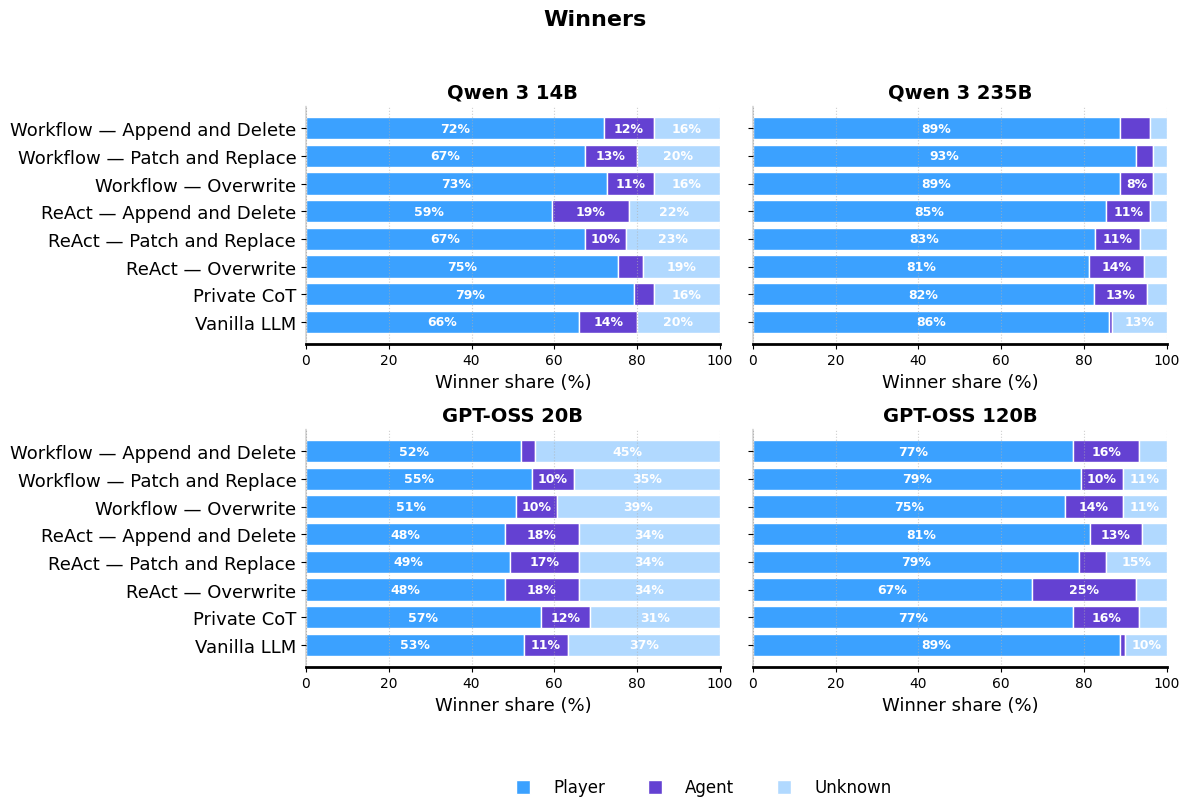

In [80]:
# === Cell: 2×2 grid — Stacked winner percentages per model (keep original agent order) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def _winner_labelize(s):  # if you need pretty labels later
    return str(s).replace("_", " ").title()

def _first_appearance_order(series):
    """Return unique values in order of first appearance (no reordering)."""
    return list(dict.fromkeys(series.tolist()))

def _winner_props_for_subset(evals_subset: pd.DataFrame) -> pd.DataFrame:
    """Return a (agents × winner) DataFrame with row-wise percentages, preserving agent order of appearance."""
    dfw = evals_subset[(evals_subset["mode"] == "behavioral") & (evals_subset["metric"] == "winner")].copy()
    if dfw.empty:
        return pd.DataFrame()

    # preserve agent order based on first appearance in this subset
    agent_order = _first_appearance_order(dfw["agent"])

    # counts -> pivot -> reindex in preserved order
    counts = (dfw.groupby(["agent", "score"]).size().unstack(fill_value=0))
    counts = counts.reindex(agent_order, fill_value=0)

    # to percentages
    row_sums = counts.sum(axis=1).replace(0, np.nan)
    props = (counts.div(row_sums, axis=0) * 100).fillna(0.0)

    # Ensure fixed winner column order
    winner_cols = ["Player", "Agent", "Unknown"]
    for c in winner_cols:
        if c not in props.columns:
            props[c] = 0.0
    props = props[winner_cols]

    return props

def _agent_label_list(agent_index):
    """Baseline → Family; others → 'Family — Strategy'."""
    labels = []
    for a in agent_index:
        fam, strat = _parse_family_strategy(a)
        labels.append(fam if strat == "Baseline" else f"{fam} — {strat}")
    return labels

def _draw_winner_stacked(ax, props: pd.DataFrame, show_yticks=True, title_str=""):
    if props.empty:
        ax.text(0.5, 0.5, "No data", ha="center", va="center")
        ax.set_axis_off()
        return

    winner_cols = ["Player", "Agent", "Unknown"]
    win_palette = {
        "Player":  PALETTE_LIST[2],
        "Agent":   PALETTE_LIST[4],
        "Unknown": PALETTE_LIST[0],
    }

    ylabels = _agent_label_list(props.index)
    y_pos = np.arange(len(ylabels))

    left = np.zeros(len(props), dtype=float)
    for w in winner_cols:
        ax.barh(
            y_pos, props[w].values, left=left,
            label=w, color=win_palette[w], edgecolor="white", height=0.8
        )
        left += props[w].values

    if show_yticks:
        ax.set_yticks(y_pos, labels=ylabels, fontsize=13)
    else:
        ax.set_yticks(y_pos, labels=[""]*len(y_pos))

    # style (match prior)
    ax.set_xlabel("Winner share (%)", fontsize=13)
    ax.set_xlim(0, 100)
    ax.grid(True, axis="x", linestyle=":", alpha=0.6)
    ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_linewidth(2)
    ax.spines["left"].set_linewidth(0.2)
    ax.set_title(title_str, fontweight="bold", fontsize=14)

    # percentage labels on sufficiently large segments
    for rect in ax.patches:
        w = rect.get_width()
        if w >= 8:
            ax.text(
                rect.get_x() + rect.get_width()/2.0,
                rect.get_y() + rect.get_height()/2.0,
                f"{w:.0f}%",
                fontsize=9, ha="center", va="center",
                color="white", weight="bold"
            )

def plot_winner_stacked_percent_grid(evals: pd.DataFrame):
    """
    2×2 grid:
      Row 1: Qwen family   [qwen_3 | qwen_3_235b]
      Row 2: GPT-OSS fam   [gpt_oss | gpt_oss_big]
    - Keep original agent order per panel (no reordering).
    - Single legend at the bottom center.
    """
    title_map = {
        "qwen_3":      "Qwen 3 14B",
        "qwen_3_235b": "Qwen 3 235B",
        "gpt_oss":     "GPT-OSS 20B",
        "gpt_oss_big": "GPT-OSS 120B",
    }

    layout = [
        ["qwen_3", "qwen_3_235b"],
        ["gpt_oss", "gpt_oss_big"],
    ]

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    for r in range(2):
        for c in range(2):
            model = layout[r][c]
            ax = axes[r, c]
            subset = evals[(evals["mode"] == "behavioral") & (evals["metric"] == "winner") & (evals["model"] == model)]
            props = _winner_props_for_subset(subset)
            _draw_winner_stacked(
                ax,
                props,
                show_yticks=(c == 0),  # y tick labels only on left plots
                title_str=title_map.get(model, model)
            )

    fig.suptitle("Winners", fontsize=16, y=0.98, fontweight="bold")

    # bottom legend (winner categories)
    winner_cols = ["Player", "Agent", "Unknown"]
    win_palette = {
        "Player":  PALETTE_LIST[2],
        "Agent":   PALETTE_LIST[4],
        "Unknown": PALETTE_LIST[0],
    }
    leg_handles = [
        plt.Line2D([0],[0], marker='s', color='none', markerfacecolor=win_palette[w],
                   markeredgecolor="white", markersize=10, label=w)
        for w in winner_cols
    ]
    fig.legend(
        handles=leg_handles,
        labels=winner_cols,
        loc=(0.42, 0.0),
        ncol=len(winner_cols),
        frameon=False, fontsize=12
    )

    fig.tight_layout(rect=[0,0.08,1,0.95])  # leave space for legend and suptitle
    plt.show()

# ---- Call ----
plot_winner_stacked_percent_grid(df)

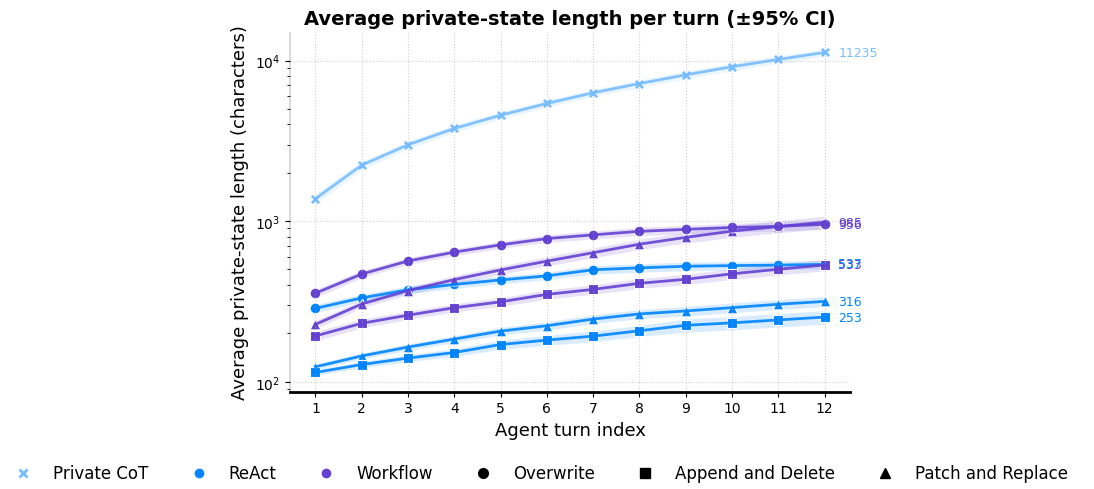

In [79]:
# === Cell: Average private-state length per turn per agent (styled like forests) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Helpers restored --------------------------------------------------------
def _agent_family(agent: str) -> str:
    return _AGENT_MAP.get(agent, (agent, ""))[0]

def _agent_strategy(agent: str) -> str:
    return _AGENT_MAP.get(agent, ("", "Baseline"))[1]

def build_private_len_long(interaction_logs: pd.DataFrame, drop_zero=True, max_turns=None):
    """
    Return long-form DF with one row per (episode, agent turn).
    Columns: model, game, agent, family, strategy, episode_id, turn_idx (1..), length
    Uses interaction_logs['private_state_lengths'] built earlier.
    """
    df = interaction_logs.copy()
    if "private_state_lengths" not in df.columns:
        raise ValueError("Expected 'private_state_lengths' on interaction_logs. Run the extraction cell first.")

    # episode id: use filepath if present, else index
    df["episode_id"] = df.get("filepath", df.index)

    # per-row turn indices aligned to lengths
    df["turn_idx_list"] = df["private_state_lengths"].apply(
        lambda L: list(range(1, len(L)+1)) if isinstance(L, (list, tuple)) else []
    )

    df_long = df.explode(["private_state_lengths", "turn_idx_list"], ignore_index=True)
    df_long = df_long.rename(columns={"private_state_lengths": "length", "turn_idx_list": "turn_idx"})

    # numeric + cleaning
    df_long["length"] = pd.to_numeric(df_long["length"], errors="coerce").fillna(0).astype(int)
    df_long["turn_idx"] = pd.to_numeric(df_long["turn_idx"], errors="coerce").astype("Int64")

    # optionally drop zeros (missing private states)
    if drop_zero:
        df_long = df_long[df_long["length"] > 0]

    # truncate number of agent turns if requested
    if max_turns is not None:
        df_long = df_long[df_long["turn_idx"].notna() & (df_long["turn_idx"] <= max_turns)]

    # enrich
    df_long["family"] = df_long["agent"].map(_agent_family)
    df_long["strategy"] = df_long["agent"].map(_agent_strategy)

    df_long = df_long[df_long["turn_idx"].notna()].copy()
    df_long["turn_idx"] = df_long["turn_idx"].astype(int)
    return df_long

def aggregate_per_turn_agent(interaction_logs, drop_zero=True, max_turns=None):
    """Aggregate mean ±95% CI of private-state length per agent & turn."""
    df_long = build_private_len_long(interaction_logs, drop_zero=drop_zero, max_turns=max_turns)

    grp = (df_long
           .groupby(["agent","family","strategy","turn_idx"])
           .agg(mean_len=("length","mean"),
                std_len=("length","std"),
                N=("length","size"))
           .reset_index())

    grp["sem"] = grp["std_len"] / np.sqrt(grp["N"])
    grp["ci"]  = 1.96 * grp["sem"]
    grp["lo"]  = (grp["mean_len"] - grp["ci"]).clip(lower=0)
    grp["hi"]  = grp["mean_len"] + grp["ci"]
    return grp

# --- Plot function (your styled version) -------------------------------------
def plot_avg_len_per_turn(interaction_logs, drop_zero=True, max_turns=None, annotate_last=True, min_sep=15):
    """
    Plot average private-state length per turn per agent with CI ribbons.
    Styled to match your forest plots.
    """
    df = aggregate_per_turn_agent(interaction_logs, drop_zero=drop_zero, max_turns=max_turns)
    if df.empty:
        print("No private-state lengths to plot."); 
        return

    fig, ax = plt.subplots(figsize=(14, 5))
    color_map = FAMILY_COLORS
    marker_map = {"Baseline":"X","Overwrite":"o","Patch and Replace":"s","Append and Delete":"^"}
    linestyle_map = {"Baseline":"-","Overwrite":"-","Patch and Replace":"-", "Append and Delete":"-"}

    last_points = []  # store (y, label, color, turn_idx)

    # One curve per agent
    for agent, d in df.groupby("agent"):
        fam = d["family"].iloc[0]
        strat = d["strategy"].iloc[0]
        color = color_map.get(fam, "#888888")
        marker = marker_map.get(strat, "o")
        lstyle = linestyle_map.get(strat, "-")

        d = d.sort_values("turn_idx")
        ax.fill_between(d["turn_idx"], d["lo"], d["hi"], alpha=0.15, color=color, linewidth=0)
        ax.plot(d["turn_idx"], d["mean_len"], lstyle, color=color, linewidth=2, alpha=0.9,
                label=f"{fam} — {strat}")
        ax.scatter(d["turn_idx"], d["mean_len"], s=60, color=color, marker=marker,
                   edgecolor="white", linewidth=0.8)

        if annotate_last and not d.empty:
            last_row = d.iloc[-1]
            last_points.append((last_row["mean_len"], f"{last_row['mean_len']:.0f}", color, last_row["turn_idx"]))

    # --- Resolve overlaps for end labels (same logic you used before) ---
    if annotate_last and last_points:
        last_points.sort(key=lambda x: x[0])  # sort by y
        adjusted_y = []
        for y, label, color, turn_idx in last_points:
            if not adjusted_y:
                adjusted_y.append(y)
            else:
                prev_y = adjusted_y[-1]
                if y - prev_y < min_sep:
                    y = prev_y + min_sep
                adjusted_y.append(y)
            ax.text(turn_idx + 0.3, y, label, color=color, fontsize=9, va="center")

    # Axes styling aligned with your forests
    ax.set_xlabel("Agent turn index", fontsize=13)
    ax.set_ylabel("Average private-state length (characters)", fontsize=13)
    ax.set_title("Average private-state length per turn (±95% CI)", fontweight="bold", fontsize=14)
    ax.grid(True, linestyle=":", alpha=0.6)
    ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_linewidth(2)
    ax.spines["left"].set_linewidth(0.2)

    # Log scale for readability across ranges
    ax.set_yscale("log")

    # Nice integer x ticks
    max_turn = int(df["turn_idx"].max())
    ax.set_xticks(range(1, max_turn+1))

    # --- Global legend at bottom: families (colors) + strategies (markers) ---
    fam_handles = [
        plt.Line2D([0],[0], marker='o', color='none', markerfacecolor=color,
                   markeredgecolor="white", markersize=8, label=fam) if fam != "Private CoT"
        else plt.Line2D([0],[0], marker='X', color='none', markerfacecolor=color,
                        markeredgecolor="white", markersize=8, label=fam)
        for fam, color in dict(list(FAMILY_COLORS.items())[1:]).items()
    ]
    strat_handles = [
        plt.Line2D([0],[0], marker=marker, color='black', linestyle='none',
                   markerfacecolor="black", markersize=7, label=strat)
        for strat, marker in {"Overwrite":"o","Patch and Replace":"s","Append and Delete":"^"}.items()
    ]

    handles = fam_handles + strat_handles
    labels = list(FAMILY_COLORS.keys())[1:] + list({"Overwrite","Patch and Replace","Append and Delete"})

    fig.legend(
        handles=handles,
        labels=labels,
        loc=(0, 0.0), ncol=len(handles),
        frameon=False, fontsize=12
    )

    fig.tight_layout(rect=[0,0.05,1,0.97])  # leave space for bottom legend
    fig.subplots_adjust(left=0.2, right=0.6)  # your padding tweak
    plt.show()

# Example
plot_avg_len_per_turn(interaction_logs, drop_zero=True, max_turns=12, annotate_last=True)

### Plot Bars

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# --- Visual palette (your colors) ---
PALETTE_LIST = [
    "#b1d9ff", "#76bdff", "#3ba1ff", "#0085ff",
    "#6441d2", "#004bba", "#48a5fb", "#cce6ff",
]

# Map families (legend) to distinct colors from your palette
FAMILY_COLORS = {
    "Vanilla LLM": PALETTE_LIST[0],
    "Private CoT": PALETTE_LIST[1],
    "ReAct":       PALETTE_LIST[3],
    "Workflow":    PALETTE_LIST[4],
}

# Nice strategy order and display names
STRATEGY_ORDER = ["Patch and Replace", "Overwrite", "Append and Delete"]

# Agent → (Family, Strategy) mapping
_AGENT_MAP = {
    "vanilla_llm": ("Vanilla LLM", "Baseline"),
    "private_cot": ("Private CoT", "Baseline"),
    "reactmem_overwrite": ("ReAct", "Overwrite"),
    "reactmem_patch_and_replace": ("ReAct", "Patch and Replace"),
    "reactmem_append_and_delete": ("ReAct", "Append and Delete"),
    "workflow_overwrite": ("Workflow", "Overwrite"),
    "workflow_patch_and_replace": ("Workflow", "Patch and Replace"),
    "workflow_append_and_delete": ("Workflow", "Append and Delete"),
}

def _prep_df(evaluations: pd.DataFrame, model: str, game: str) -> pd.DataFrame:
    """Filter by game and enrich with Family/Strategy columns."""
    df = evaluations[(evaluations["game"] == game) & (evaluations["model"] == model)].copy()
    # Map family and strategy
    fam_str = df["agent"].map(lambda a: _AGENT_MAP.get(a, (a, a)))
    df["family"] = fam_str.map(lambda t: t[0])
    df["strategy"] = fam_str.map(lambda t: t[1])
    return df

def _cluster_positions(fams_present, fam_order, cluster_width=0.8):
    """
    Return dict {family: (offset, bar_w)} with a fixed 2-slot layout.
    - bar_w is cluster_width/2 (constant).
    - If only one family present, center it (offset = 0).
    - If two present, place them left/right so they touch.
    """
    fams_present = [f for f in fam_order if f in fams_present]
    bar_w = cluster_width / 2.0
    if len(fams_present) <= 1:
        return {fams_present[0]: (0.0, bar_w)} if fams_present else {}
    # two families: left/right around the tick
    left_off  = -bar_w / 2.0
    right_off =  bar_w / 2.0
    return {
        fams_present[0]: (left_off,  bar_w),
        fams_present[1]: (right_off, bar_w),
    }

def _nice_axes_style(ax, grid_axis="y"):
    """Apply the requested clean style to one axes."""
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.tick_params(left=False, bottom=False)
    # Hide top/right, keep one heavy border as in the template
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    if grid_axis == "y":
        ax.spines["left"].set_visible(False)
        ax.spines["bottom"].set_linewidth(2)
        ax.yaxis.grid(True, which="major", linestyle=":")
    else:
        ax.spines["bottom"].set_visible(False)
        ax.spines["left"].set_linewidth(2)
        ax.xaxis.grid(True, which="major", linestyle=":")
    ax.set_axisbelow(True)

def _barvalue_labels(ax, fmt="{:.0f}", min_abs_height=0.1, inside=True):
    """Write values onto vertical bars (centered & bold white like template)."""
    for rect in ax.patches:
        h = rect.get_height()
        if abs(h) >= min_abs_height:
            x = rect.get_x() + rect.get_width() / 2.0
            y = rect.get_y() + h / 2.0 if inside else h
            ax.text(
                x, y if inside else h,
                fmt.format(h),
                fontsize=10, ha="center",
                va="center" if inside else "bottom",
                color="white", weight="bold",
            )

def _plot_metric_panel(
    ax, df_sub, title, y_label=None, rotate_xticks=20, 
    exclude_families=None, include_baseline_tick=True, 
    ylim=[0, 5.6],
    ):
    """
    Bar plot with x=strategy (only 3 strategies), hue=family.
    Baselines (family in {'Vanilla LLM','Private CoT'}) are repeated across
    strategies as reference bars so they appear in each cluster.
    """
    if df_sub.empty:
        ax.set_visible(False)
        return []

        # ---- REPLACE plotting code in _plot_metric_panel with this ----

    # Map family/strategy first so we can filter by family
    d = df_sub.copy()
    d["family"] = d["agent"].map(lambda a: _AGENT_MAP[a][0])
    d["strategy"] = d["agent"].map(lambda a: _AGENT_MAP[a][1])

    # Optional: drop families (e.g., Vanilla LLM) for specific panels
    if exclude_families:
        d = d[~d["family"].isin(exclude_families)]

    # Aggregate after filtering
    g = d.groupby(["agent", "family", "strategy"], as_index=False)["score"].mean()

    # Aggregate means per agent, then map to family/strategy
    # g = df_sub.groupby("agent", as_index=False)["score"].mean()
    g["family"] = g["agent"].map(lambda a: _AGENT_MAP[a][0])
    g["strategy"] = g["agent"].map(lambda a: _AGENT_MAP[a][1])

    # Split
    base = g[g["strategy"] == "Baseline"].copy()
    mem  = g[g["strategy"] != "Baseline"].copy()

    # Prepare positions
    # Cluster positions: Baseline + 3 strategies as real ticks
    strategies = STRATEGY_ORDER  # ["Patch and Replace", "Overwrite", "Append and Delete"]
    if include_baseline_tick:
        CLUSTERS = ["Baseline"] + strategies
    else:
        CLUSTERS = strategies
    x_pos = {name: i for i, name in enumerate(CLUSTERS)}  # Baseline=0, then 1..3
    x_baseline = -1

    families = list(FAMILY_COLORS.keys())                   # ['Vanilla LLM','Private CoT','ReAct','Workflow']
    width = 0.18
    # Hue offsets: spread families evenly inside each cluster
    hue_offsets = {
        fam: (i - (len(families)-1)/2) * width
        for i, fam in enumerate(families)
    }

        # --- Draw baseline cluster (x at tick "Baseline") ---
    if include_baseline_tick and not base.empty:
        fam_order_base = ["Private CoT", "Vanilla LLM"]
        fams_present = list(base["family"].unique())
        pos = _cluster_positions(fams_present, fam_order_base, cluster_width=0.8)

        for fam, (off, bar_w) in pos.items():
            val = float(base.loc[base["family"] == fam, "score"].mean())
            ax.bar(
                x_pos["Baseline"] + off,
                val,
                width=bar_w,
                color=FAMILY_COLORS[fam],
                edgecolor="white",
                label=fam,
            )

        # --- Draw each strategy cluster at its tick ---
    for s in strategies:
        fams = list(mem.loc[mem["strategy"] == s, "family"].unique())
        if not fams:
            continue
        n_f = len(fams)
        cluster_width = 0.8
        bar_w = cluster_width / n_f
        offsets = np.arange(n_f) * bar_w - (cluster_width - bar_w) / 2
        for off, fam in zip(offsets, fams):
            val = float(mem.loc[(mem["strategy"] == s) & (mem["family"] == fam), "score"].mean())
            ax.bar(
                x_pos[s] + off,
                val,
                width=bar_w,
                color=FAMILY_COLORS[fam],
                edgecolor="white",
                label=fam,
            )


        # X ticks: Baseline + strategies (with slight rotation)
    ax.set_xticks([x_pos[name] for name in CLUSTERS])
    ax.set_xticklabels(CLUSTERS, rotation=rotate_xticks, ha="right")

    # Light style & grids like your template
    _nice_axes_style(ax, grid_axis="y")

    # Add value labels on all bars
    for rect in ax.patches:
        h = rect.get_height()
        if abs(h) >= 0.02:
            x = rect.get_x() + rect.get_width() / 2.0
            y = rect.get_y() + h / 2.0
            ax.text(
                x, y, f"{h:.2f}",
                fontsize=10, ha="center", va="center",
                color="white", weight="bold",
            )

    # Expand x-limits so the baseline cluster is visible
    # ax.set_xlim(x_baseline - 0.8, max(x_pos.values()) + 0.8)
        # Nicely pad first and last clusters
    ax.set_xlim(-0.6, len(CLUSTERS) - 1 + 0.6)
    ax.set_ylim(ylim)

    # Add a subtle "Baseline" label under the baseline cluster (not a tick)
    ymin, ymax = ax.get_ylim()
    ax.text(
        x_baseline, ymin - 0.03*(ymax - ymin),
        "Baseline", ha="center", va="top", fontsize=9,
        transform=ax.transData
    )

    # Title / labels
    ax.set_title(title, pad=6)
    if y_label:
        ax.set_ylabel(y_label)

    # Return legend handles/labels (families) for the global legend
    handles = [plt.Rectangle((0,0),1,1,color=FAMILY_COLORS[f]) for f in families]
    labels  = families
    return list(zip(handles, labels))

def _winner_labelize(s):
    """Title-case + spaces for winner categories (e.g., 'user_win' -> 'User Win')."""
    return str(s).replace("_", " ").title()

def _agent_nice(a):
    """Pretty y-tick labels for winners row."""
    fam, strat = _AGENT_MAP.get(a, (a, a))
    if strat == "Baseline":
        return fam  # 'Vanilla LLM' or 'Private CoT'
    return f"{fam} — {strat}"

def plot_all_metrics(evaluations, model, game):
    """
    Layout (5 rows × 2 cols):
      r1: memory intentionality | memory secrecy
      r2: memory mechanism      | memory coherence
      r3: behavioral secrecy    | behavioral coherence
      r4: rule-based secrecy    | rule-based intentionality
      r5: winners (spans both columns)
    - Bars: x = Strategy (Patch/Overwrite/Delete+Append), hue = Family.
            Baselines (Vanilla LLM / Private CoT) appear in each strategy cluster.
    - Winners: horizontal stacked counts per agent, with nice labels.
    - Single, figure-level legend for families (+ winner outcomes).
    """

    df = _prep_df(evaluations, model, game)

    # Figure & grid (use constrained layout to avoid overlaps)
    fig = plt.figure(figsize=(16, 22), constrained_layout=True)
    gs = GridSpec(5, 2, figure=fig, height_ratios=[1,1,1,1,1.2])

    legend_items = []

    # Row 1: Memory (mechanism, coherence)
    ax_m_mec = fig.add_subplot(gs[0, 0])
    items = _plot_metric_panel(
        ax_m_mec,
        df[(df["mode"] == "memory") & (df["metric"] == "mechanism")],
        "Mechanism (Memory)", y_label="Mean Score",
        exclude_families={"Vanilla LLM"}  # 👈 NEW
    ); legend_items += items

    ax_m_coh = fig.add_subplot(gs[0, 1])
    items = _plot_metric_panel(
        ax_m_coh,
        df[(df["mode"] == "memory") & (df["metric"] == "coherence")],
        "Coherence (Memory)", y_label="Mean Score",
        exclude_families={"Vanilla LLM"}  # 👈 NEW
    ); legend_items += items

    # Row 2: Memory (intentionality, secrecy)
    ax_m_sec = fig.add_subplot(gs[1, 0])
    items = _plot_metric_panel(
        ax_m_sec,
        df[(df["mode"] == "memory") & (df["metric"] == "secrecy")],
        "Secrecy (Memory)", y_label="Mean Score",
        exclude_families={"Vanilla LLM"}  # 👈 NEW
    ); legend_items += items
    
    ax_m_int = fig.add_subplot(gs[1, 1])
    items = _plot_metric_panel(
        ax_m_int,
        df[(df["mode"] == "memory") & (df["metric"] == "intentionality")],
        "Intentionality (Memory)", y_label="Mean Score",
        exclude_families={"Vanilla LLM"}  # 👈 NEW
    ); legend_items += items

    # --- Row 3: Behavioral (secrecy, coherence) ---
    ax_b_sec = fig.add_subplot(gs[2, 0])
    items = _plot_metric_panel(
        ax_b_sec,
        df[(df["mode"] == "behavioral") & (df["metric"] == "secrecy")],
        "Secrecy (Behavioral)", y_label="Mean Score"
    ); legend_items += items

    ax_b_coh = fig.add_subplot(gs[2, 1])
    items = _plot_metric_panel(
        ax_b_coh,
        df[(df["mode"] == "behavioral") & (df["metric"] == "coherence")],
        "Coherence (Behavioral)", y_label="Mean Score"
    ); legend_items += items

    # --- Row 4: Rule-based (secrecy, intentionality) ---
    ax_r_sec = fig.add_subplot(gs[3, 0])
    items = _plot_metric_panel(
        ax_r_sec,
        df[(df["mode"] == "rule_based") & (df["metric"] == "secrecy")],
        "Secrecy (Rule-Based)", y_label="Mean Score", 
        include_baseline_tick=False, ylim=[0, 1]
    ); legend_items += items

    ax_r_int = fig.add_subplot(gs[3, 1])
    items = _plot_metric_panel(
        ax_r_int,
        df[(df["mode"] == "rule_based") & (df["metric"] == "intentionality")],
        "Intentionality (Rule-Based)", y_label="Mean Score",
        include_baseline_tick=False, ylim=[0, 1]
    ); legend_items += items

    # --- Row 5: Winners (stacked, spans both columns) ---
    ax_win = fig.add_subplot(gs[4, :])
    df_win = df[(df["mode"] == "behavioral") & (df["metric"] == "winner")]

    winner_handles = []
    if not df_win.empty:
        # Count per agent -> columns = winner categories
        counts = (df_win.groupby(["agent", "score"])
                  .size().unstack(fill_value=0))

        # Stable agent order: use mapping order from _AGENT_MAP keys
        agent_order = [a for a in _AGENT_MAP if a in counts.index]
        counts = counts.reindex(agent_order, fill_value=0)

        # Nice y tick labels (Family — Strategy, or Family for baselines)
        ylabels = [ _agent_nice(a) for a in counts.index ]
        y_pos = np.arange(len(ylabels))

        # Winner categories + colors (take remaining colors from your palette)
        winner_cols = [ _winner_labelize(c) for c in counts.columns ]
        raw_cols = list(counts.columns)
        # map raw -> nice
        counts.columns = winner_cols

        # Build a small color dict for winners using distinct but related tones
        # reuse palette list deterministically
        win_palette = {
            "Player": PALETTE_LIST[2],
            "Agent": PALETTE_LIST[4],
            "Unknown": PALETTE_LIST[0],
        }
        # for i, w in enumerate(winner_cols):
        #     win_palette[w] = PALETTE_LIST[(i % len(PALETTE_LIST))]

        left = np.zeros(len(counts), dtype=float)
        for w in winner_cols:
            bars = ax_win.barh(
                y_pos, counts[w].values, left=left,
                label=w, color=win_palette[w], edgecolor="white"
            )
            left += counts[w].values

        # Style & labels
        ax_win.set_yticks(y_pos, labels=ylabels)
        ax_win.set_xlabel("")
        ax_win.set_ylabel("")
        ax_win.set_title("Winners (Behavioral)", pad=6)
        _nice_axes_style(ax_win, grid_axis="x")

        # Value labels inside segments (like template)
        for rect in ax_win.patches:
            w = rect.get_width()
            if w > 0.5:  # avoid clutter for tiny segments
                ax_win.text(
                    rect.get_x() + rect.get_width()/2.0,
                    rect.get_y() + rect.get_height()/2.0,
                    f"{w:.0f}",
                    fontsize=10, ha="center", va="center",
                    color="white", weight="bold"
                )

        # Collect winner legend items for global legend
        winner_handles = [plt.Rectangle((0,0),1,1, color=win_palette[w]) for w in winner_cols]
        winner_labels  = winner_cols
    else:
        ax_win.set_visible(False)
        winner_handles, winner_labels = [], []

    # --- Single, figure-level legend ---
    # Deduplicate (family) items first; then append winner items.
    fam_seen = set()
    fam_handles, fam_labels = [], []
    for h, lab in legend_items:
        if lab not in fam_seen:
            fam_seen.add(lab)
            fam_handles.append(h)
            fam_labels.append(lab)

    # Global legend for families only
    if fam_handles:
        fig.legend(
            handles=fam_handles, labels=fam_labels,
            loc='upper center', bbox_to_anchor=(0.5, 1.04),
            ncol=len(fam_handles), frameon=False, 
            fontsize=12
        )

    # Separate legend for winners, close to the winners subplot
    if winner_handles:
        ax_win.legend(
            handles=winner_handles, labels=winner_labels,
            loc='upper right', bbox_to_anchor=(1.0, 1.1),
            ncol=len(winner_handles), frameon=False,
            title="Winner"
        )

    # --- Bold Suptitle ---

    fig.suptitle(game.replace("_", " ").title(), fontsize=24, y=1.07, fontweight="semibold")

    plt.show()

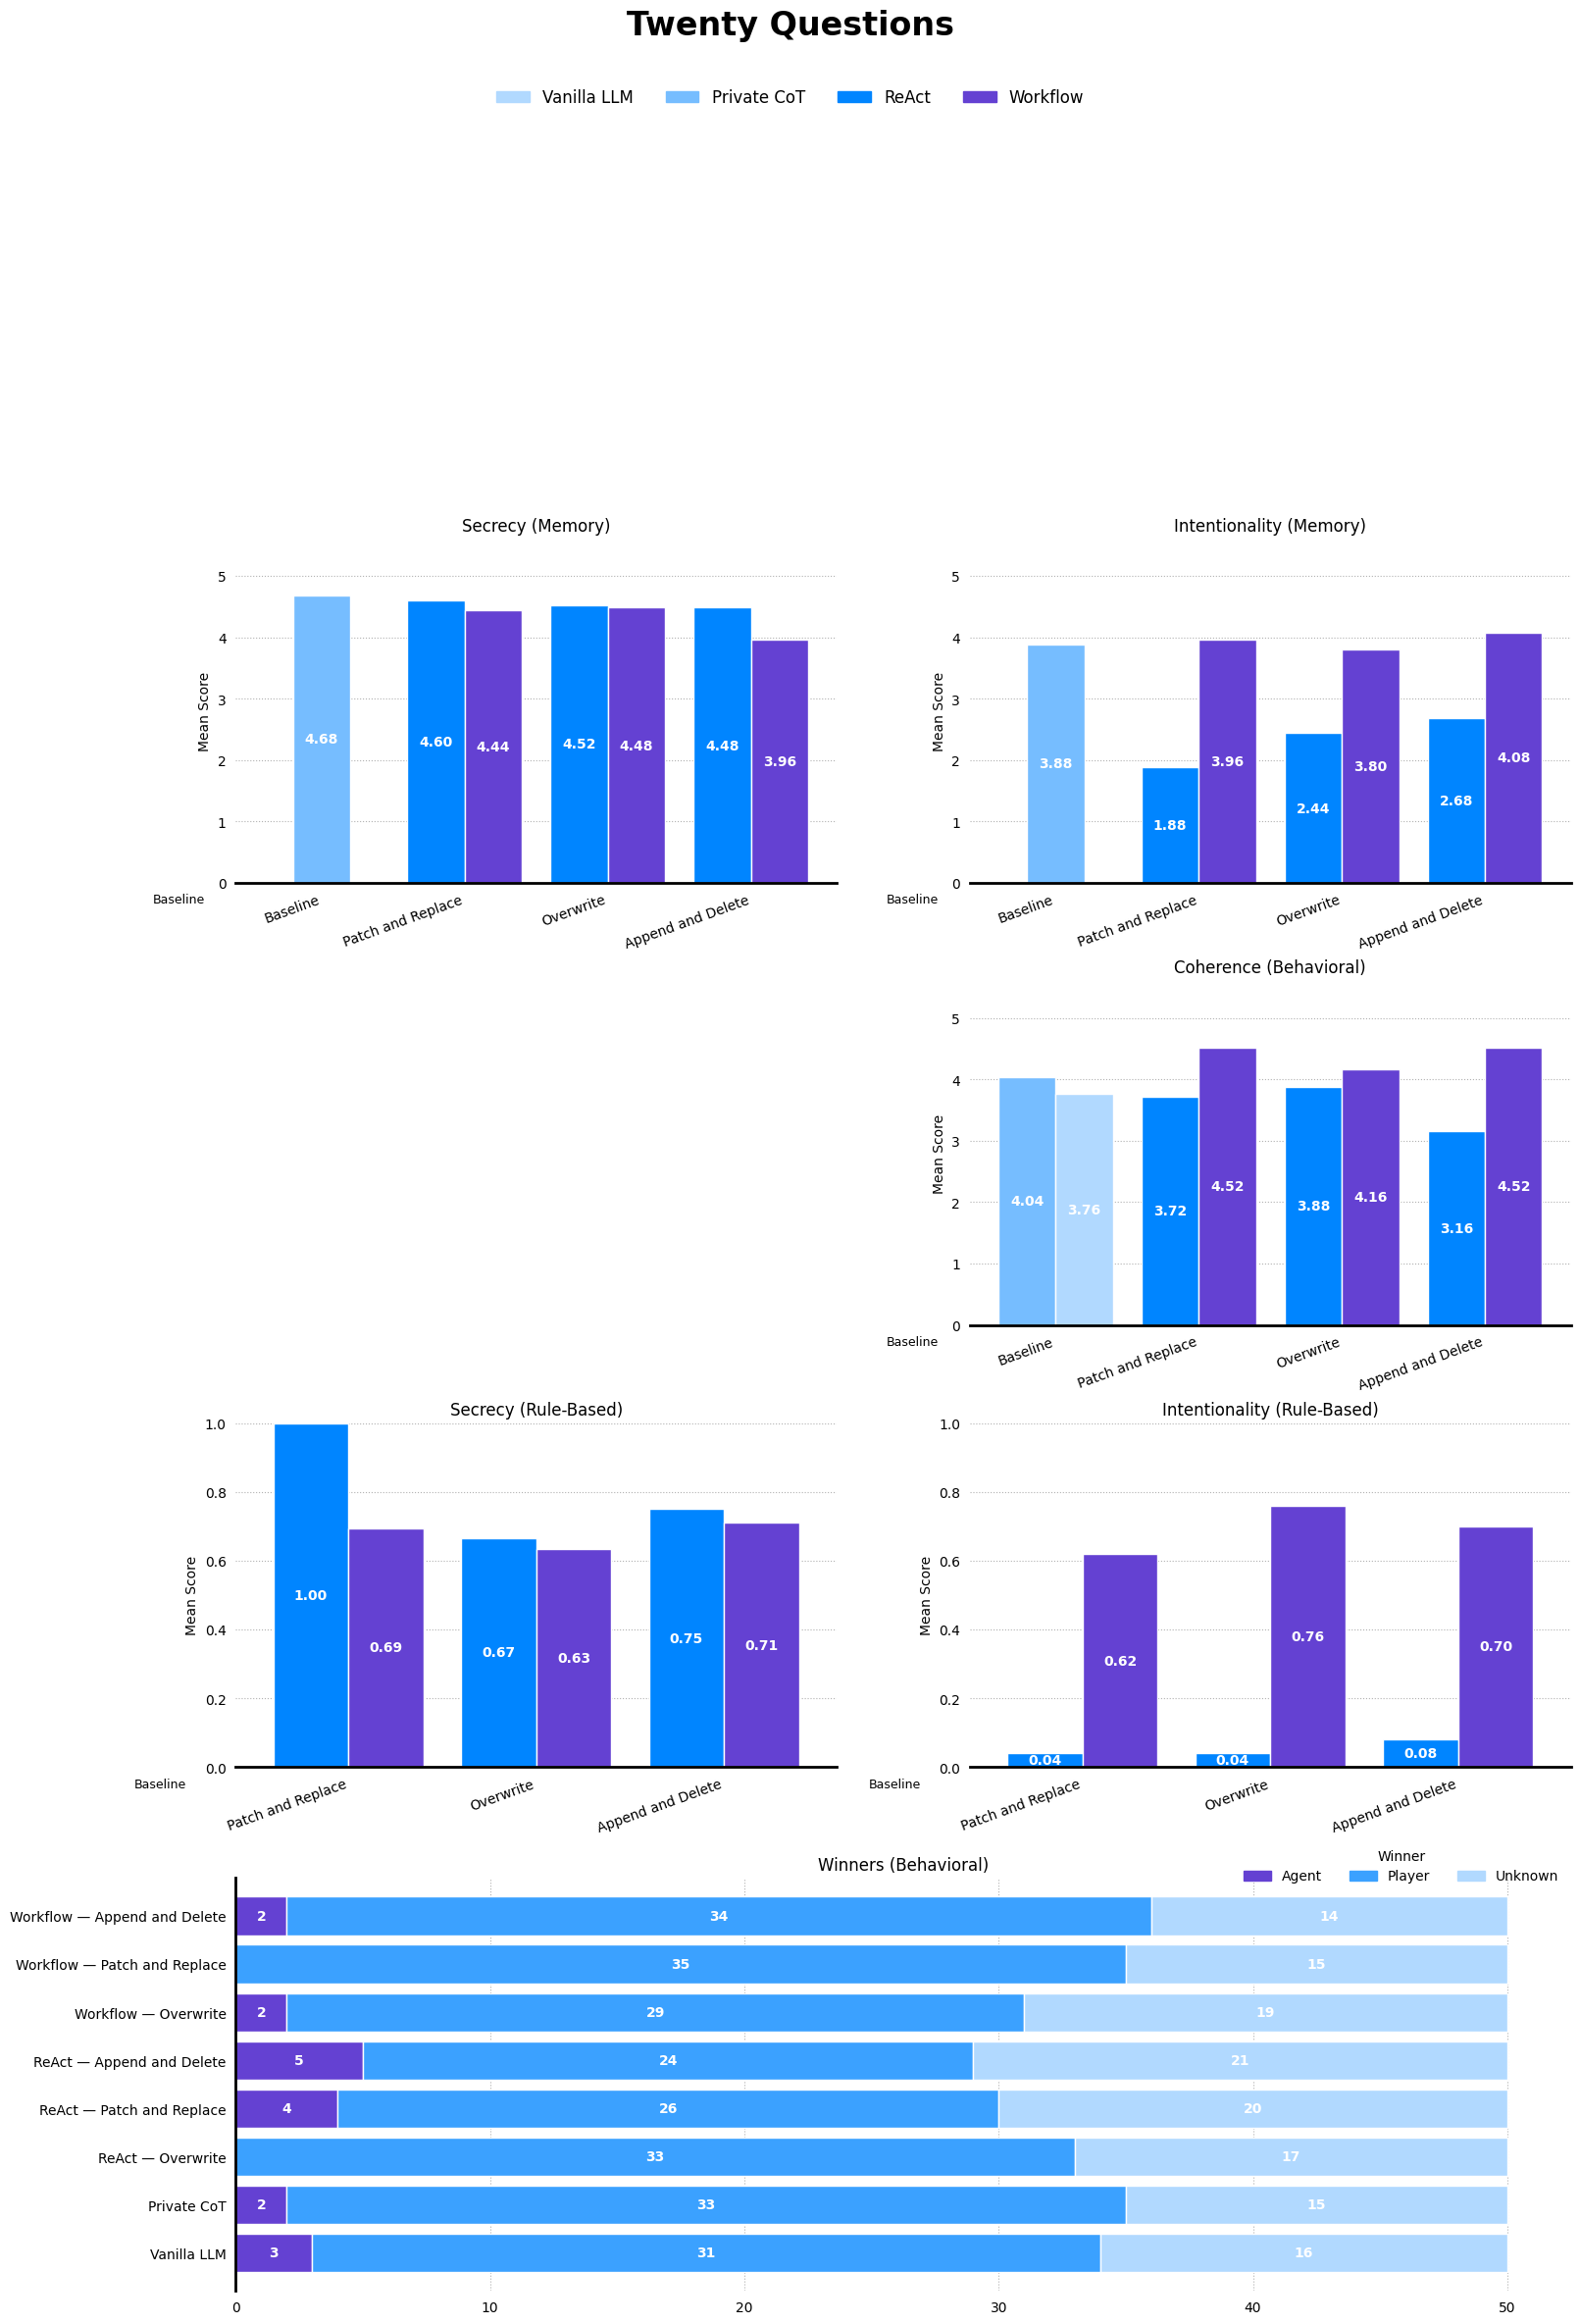

In [18]:
plot_all_metrics(evaluations=evaluations, game='twenty_questions', model='qwen_3')

In [15]:
eval_numeric_summary = evaluations_numeric.groupby(['model', 'game', 'agent', 'mode', 'metric'])['score'].mean()

In [20]:
evaluations.agent.unique()

array(['vanilla_llm', 'private_cot', 'reactmem_overwrite',
       'reactmem_patch_and_replace', 'reactmem_append_and_delete',
       'workflow_overwrite', 'workflow_patch_and_replace',
       'workflow_append_and_delete'], dtype=object)

In [32]:
evaluations_sub = evaluations[evaluations.model.isin(['gpt_oss', 'qwen_3'])]

### Other plots

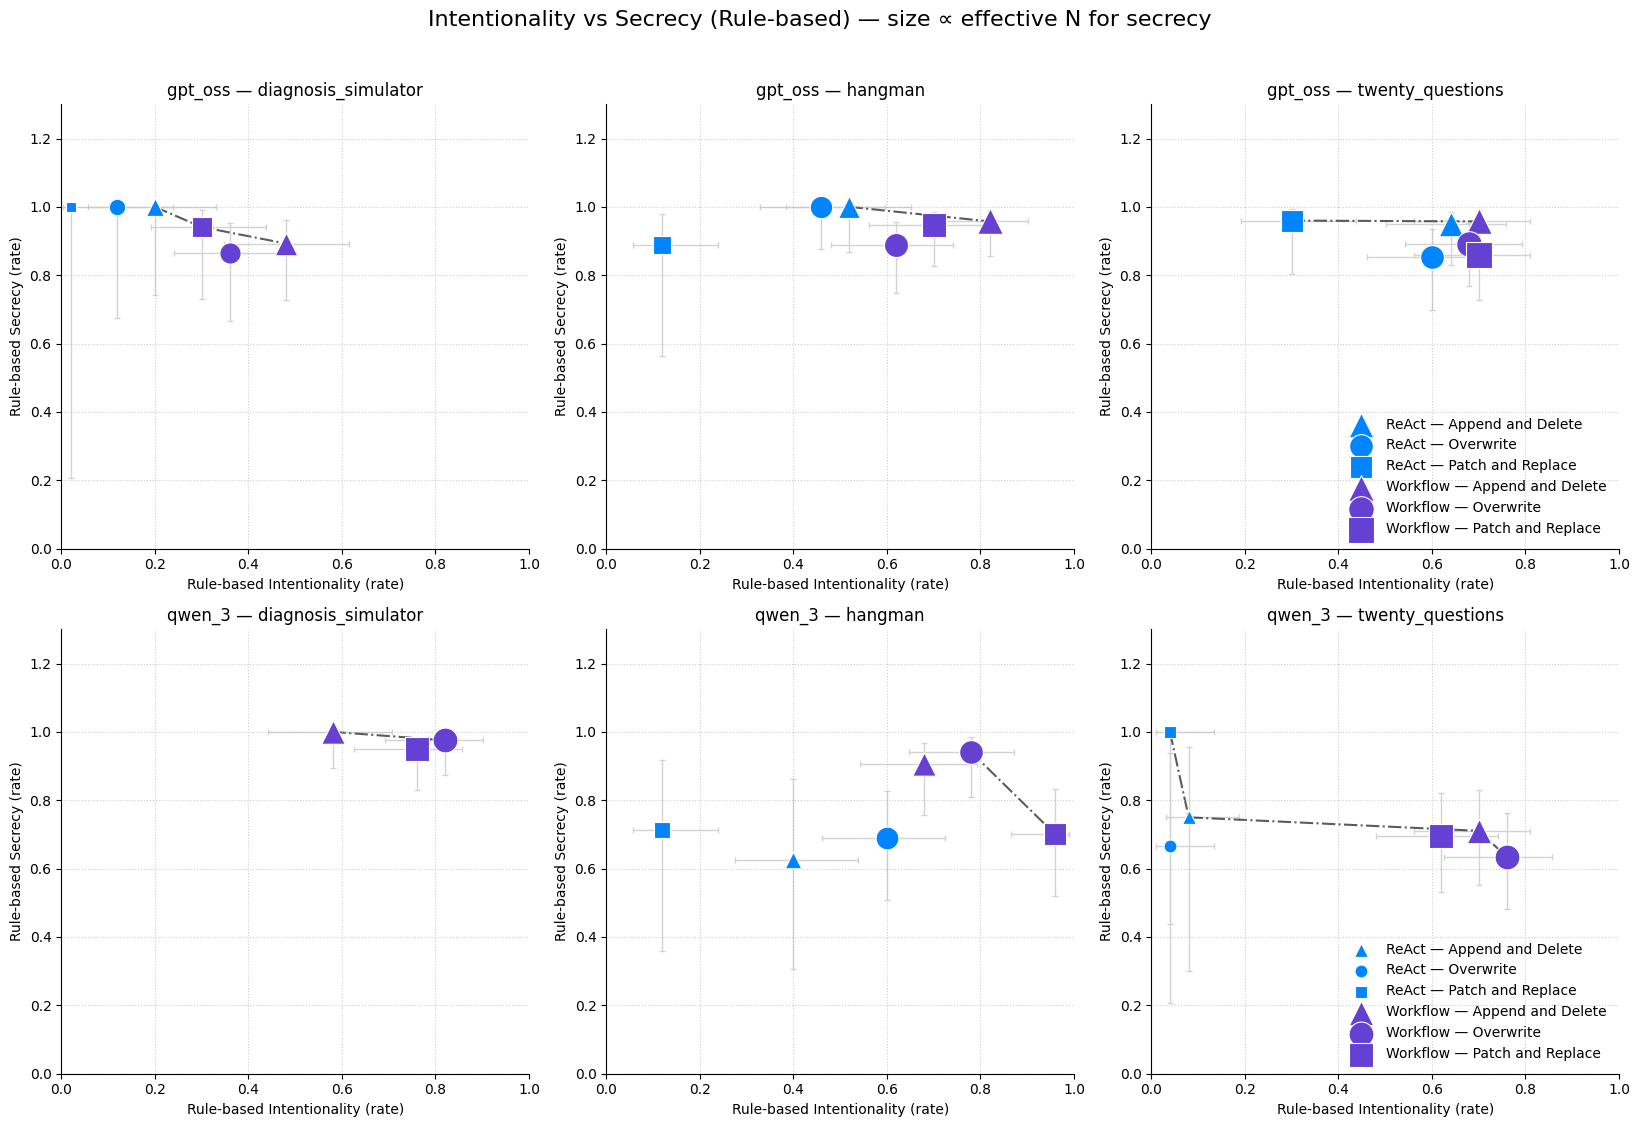

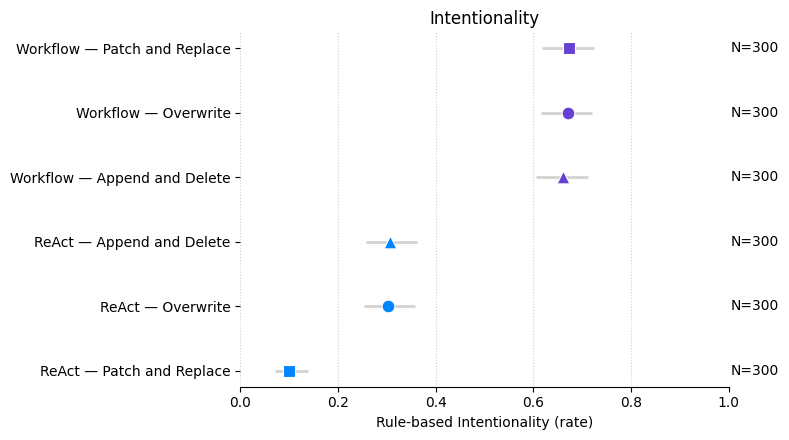

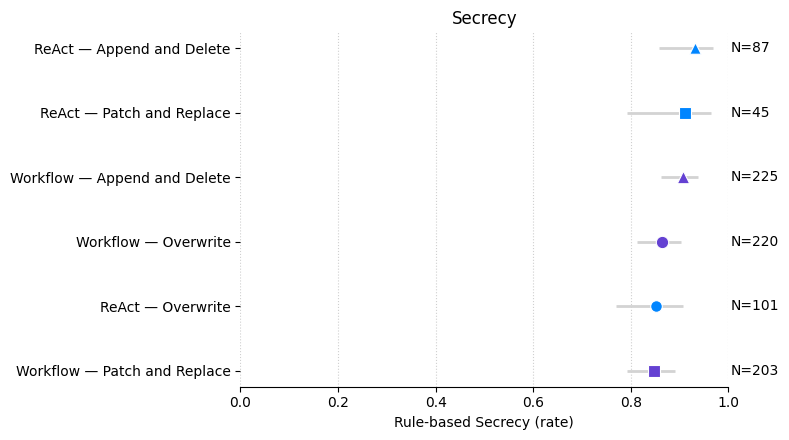

In [18]:
# === Cell 4: Rule-based plots (Intentionality & Secrecy) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
from math import sqrt

evaluations_sub = evaluations[evaluations.model.isin(['gpt_oss', 'qwen_3'])]

# --- Config: agents that have rule-based metrics ---
RULE_AGENTS = [
    'reactmem_overwrite',
    'reactmem_patch_and_replace',
    'reactmem_append_and_delete',
    'workflow_overwrite',
    'workflow_patch_and_replace',
    'workflow_append_and_delete',
]

# --- Family/Strategy helpers (reuse your mapping/colors) ---
FAMILY = {"reactmem": "ReAct", "workflow": "Workflow"}
STRAT = {
    "overwrite": "Overwrite",
    "patch_and_replace": "Patch and Replace",
    "append_and_delete": "Append and Delete",
}

def parse_family(agent):
    return FAMILY["reactmem" if agent.startswith("reactmem_") else "workflow"]

def parse_strategy(agent: str) -> str:
    # works even if a baseline sneaks in
    tail = None
    if agent.startswith("reactmem_"):
        tail = agent[len("reactmem_"):]
    elif agent.startswith("workflow_"):
        tail = agent[len("workflow_"):]
    return STRAT.get(tail, "Baseline")

def wilson_ci(k, n, z=1.96):
    """Wilson score interval for a binomial proportion."""
    if n <= 0:
        return (np.nan, np.nan)
    p_hat = k / n
    denom = 1 + z**2 / n
    center = (p_hat + z**2/(2*n)) / denom
    rad = z * sqrt((p_hat*(1-p_hat) + z**2/(4*n)) / n) / denom
    return center - rad, center + rad

def _aggregate_rule_metrics(evals: pd.DataFrame, pool_over=("model","game")):
    """
    Build a summary per (pool dims..., agent) with:
      - intent_rate, intent_lo, intent_hi, N_intent
      - secrecy_rate, secr_lo, secr_hi, N_secr
      - coverage = N_secr / N_intent
    Only uses RULE_AGENTS.
    """
    df = evals[(evals["mode"]=="rule_based") & (evals["agent"].isin(RULE_AGENTS))].copy()

    # Separate intent & secrecy rows
    intent = df[df["metric"]=="intentionality"]
    secr   = df[df["metric"]=="secrecy"]

    # Counts
    grp_cols = list(pool_over) + ["agent"]
    g_int = (
        intent.groupby(grp_cols)["score"]
        .agg(lambda s: (np.sum(s.astype(bool)), len(s)))  # (successes, total)
        .reset_index()
        .rename(columns={"score": "intent_tuple"})
    )

    g_sec = (
        secr.groupby(grp_cols)["score"]
        .agg(lambda s: (np.sum(s.astype(bool)), len(s)))  # (successes, total where defined)
        .reset_index()
        .rename(columns={"score": "secr_tuple"})
    )

    agg = pd.merge(g_int, g_sec, on=grp_cols, how="left")

    # Expand tuples, compute rates + Wilson CIs
    out_rows = []
    for _, row in agg.iterrows():
        succ_i, n_i = row["intent_tuple"]
        if pd.isna(row["secr_tuple"]):
            succ_s, n_s = 0, 0
        else:
            succ_s, n_s = row["secr_tuple"]

        ir = succ_i / n_i if n_i > 0 else np.nan
        il, ih = wilson_ci(succ_i, n_i)

        sr = succ_s / n_s if n_s > 0 else np.nan
        sl, sh = wilson_ci(succ_s, n_s)

        out = {c: row[c] for c in grp_cols}
        out.update({
            "intent_rate": ir, "intent_lo": il, "intent_hi": ih, "N_intent": int(n_i),
            "secrecy_rate": sr, "secr_lo": sl, "secr_hi": sh, "N_secr": int(n_s),
            "coverage": (n_s / n_i) if n_i > 0 else np.nan,
            "family": parse_family(row["agent"]),
            "strategy": parse_strategy(row["agent"]),
        })
        out_rows.append(out)

    res = pd.DataFrame(out_rows)
    return res

def _pareto_frontier(points):
    """
    Given array-like of (x, y), return boolean mask for non-dominated points
    (maximize both x and y).
    """
    pts = np.asarray(points, float)
    keep = np.ones(len(pts), dtype=bool)
    for i, (xi, yi) in enumerate(pts):
        if np.isnan(xi) or np.isnan(yi):
            keep[i] = False
            continue
        # dominated if some j has x>=xi and y>=yi and at least one strict
        for j, (xj, yj) in enumerate(pts):
            if j == i: 
                continue
            if (xj >= xi) and (yj >= yi) and ((xj > xi) or (yj > yi)):
                keep[i] = False
                break
    return keep

# ---------- PLOT 1: Trade-off scatter with Pareto frontier ----------
def plot_tradeoff_scatter(evals, models=None, games=None, s_scale=50):
    """
    Facets: rows = models (or pooled), cols = games (or pooled).
    Each panel: x=intent_rate, y=secrecy_rate, size ~ N_secr, error bars = Wilson CIs.
    Color = family, marker = strategy. Pareto frontier highlighted.
    """
    df_all = _aggregate_rule_metrics(evals, pool_over=("model","game"))
    if models is not None:
        df_all = df_all[df_all["model"].isin(models)]
    if games is not None:
        df_all = df_all[df_all["game"].isin(games)]

    # facet values (or pooled)
    mod_vals = sorted(df_all["model"].unique()) if (models is None) else models
    game_vals = sorted(df_all["game"].unique()) if (games is None) else games
    if len(mod_vals)==0 or len(game_vals)==0:
        print("No data to plot.")
        return

    # basic style
    fam_color = FAMILY_COLORS
    strat_marker = {"Overwrite":"o", "Patch and Replace":"s", "Append and Delete":"^"}

    n_rows, n_cols = len(mod_vals), len(game_vals)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5.5*n_cols, 5.5*n_rows), squeeze=False)

    for i, m in enumerate(mod_vals):
        for j, g in enumerate(game_vals):
            ax = axes[i, j]
            d = df_all[(df_all["model"]==m) & (df_all["game"]==g)].copy()

            # error bars + points
            for _, r in d.iterrows():
                if not (np.isfinite(r["intent_rate"]) and np.isfinite(r["secrecy_rate"])):
                    continue
                # horizontal (intentionality)
                ax.errorbar(
                    r["intent_rate"], r["secrecy_rate"],
                    xerr=[[r["intent_rate"] - r["intent_lo"]], [r["intent_hi"] - r["intent_rate"]]],
                    yerr=[[r["secrecy_rate"] - r["secr_lo"]], [r["secr_hi"] - r["secrecy_rate"]]],
                    fmt="none", ecolor="lightgray", elinewidth=1, capsize=2, zorder=1
                )
            # points
            for _, r in d.iterrows():
                if not (np.isfinite(r["intent_rate"]) and np.isfinite(r["secrecy_rate"])):
                    continue
                ax.scatter(
                    r["intent_rate"], r["secrecy_rate"],
                    s=max(10, s_scale * np.sqrt(max(r["N_secr"], 1))),  # emphasize effective N
                    c=fam_color[r["family"]],
                    marker=strat_marker[r["strategy"]],
                    edgecolor="white", linewidth=0.8, zorder=2,
                    label=(r["family"] + " — " + r["strategy"])
                )

            # Pareto frontier
            pts = d[["intent_rate","secrecy_rate"]].to_numpy()
            mask = _pareto_frontier(pts)
            frontier = d[mask]
            if len(frontier) >= 2:
                # order along x for a pretty polyline
                fr = frontier.sort_values("intent_rate")
                ax.plot(fr["intent_rate"], fr["secrecy_rate"], linestyle="-.", linewidth=1.5, color="#333333", alpha=0.8, zorder=1)

            # cosmetics
            ax.set_xlim(0, 1); ax.set_ylim(0, 1.3)
            ax.set_xlabel("Rule-based Intentionality (rate)")
            ax.set_ylabel("Rule-based Secrecy (rate)")
            ax.set_title(f"{m} — {g}")
            ax.grid(True, axis="both", linestyle=":", alpha=0.6)
            ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)

            # compact legend: unique label entries
            handles, labels = ax.get_legend_handles_labels()
            uniq = dict(zip(labels, handles))
            if j == n_cols-1:  # show only on rightmost in each row
                ax.legend(uniq.values(), uniq.keys(), frameon=False, fontsize=10, loc="lower right")

    fig.suptitle("Intentionality vs Secrecy (Rule-based) — size ∝ effective N for secrecy", y=1.02, fontsize=16)
    fig.tight_layout()
    plt.show()

# ---------- PLOT 2: Forest / Dot plots (ranked) ----------
def plot_forest_ranked(evals, metric="intentionality", pool=True, per_model=None, per_game=None):
    """
    Cleveland dot/forest plot for a rule-based metric ('intentionality' or 'secrecy').
    If pool=True, pools over (model, game); else facet by per_model or per_game.
    Sorted by point estimate, with Wilson 95% CIs and N in labels.
    """
    assert metric in ("intentionality","secrecy")
    pool_over = () if pool else (("model",) if per_model else ("game",))
    cols = ("model",) if per_model else (("game",) if not pool else ())

    # aggregate
    agg = _aggregate_rule_metrics(evals, pool_over=("model","game"))
    rate_col = "intent_rate" if metric=="intentionality" else "secrecy_rate"
    lo_col   = "intent_lo"   if metric=="intentionality" else "secr_lo"
    hi_col   = "intent_hi"   if metric=="intentionality" else "secr_hi"
    N_col    = "N_intent"    if metric=="intentionality" else "N_secr"

    if pool:
        # collapse across (model,game) by summing successes & totals before CI
        # We recompute pooled CIs correctly.
        df = evals[(evals["mode"]=="rule_based") & (evals["agent"].isin(RULE_AGENTS))]
        df = df[df["metric"]==metric]
        tmp = (df.groupby("agent")["score"]
                 .agg(lambda s: (np.sum(s.astype(bool)), len(s)))
                 .reset_index())
        rows = []
        for _, r in tmp.iterrows():
            succ, n = r["score"]
            p = succ/n if n>0 else np.nan
            lo, hi = wilson_ci(succ, n)
            rows.append({
                "agent": r["agent"], rate_col: p, lo_col: lo, hi_col: hi, N_col: int(n),
                "family": parse_family(r["agent"]), "strategy": parse_strategy(r["agent"])
            })
        plot_df = pd.DataFrame(rows)
        title_suffix = " (pooled over model & game)"
        facets = [("pooled", plot_df)]
    else:
        # one facet per value in the chosen dimension
        dim = "model" if per_model else "game"
        facets = []
        for val in sorted(agg[dim].unique()):
            # Proper pooling across the remaining dimension, but ONLY for rule agents
            df_metric = evals[
                (evals["mode"] == "rule_based")
                & (evals["metric"] == metric)
                & (evals["agent"].isin(RULE_AGENTS))
                & (evals[dim] == val)
            ]
            if df_metric.empty:
                continue
            d2 = (df_metric.groupby("agent")["score"]
                            .agg(lambda s: (np.sum(s.astype(bool)), len(s)))
                            .reset_index())
            rows = []
            for _, r in d2.iterrows():
                succ, n = r["score"]
                p = succ/n if n > 0 else np.nan
                lo, hi = wilson_ci(succ, n)
                rows.append({
                    "agent": r["agent"],
                    ("intent_rate" if metric=="intentionality" else "secrecy_rate"): p,
                    ("intent_lo"   if metric=="intentionality" else "secr_lo"): lo,
                    ("intent_hi"   if metric=="intentionality" else "secr_hi"): hi,
                    ("N_intent"    if metric=="intentionality" else "N_secr"): int(n),
                    "family": parse_family(r["agent"]),
                    "strategy": parse_strategy(r["agent"]),
                })
            facets.append((val, pd.DataFrame(rows)))
        title_suffix = f" (per {dim})"

    # Plot each facet
    for facet_name, d in facets:
        d = d.sort_values(rate_col, ascending=True)
        y = np.arange(len(d))
        fig, ax = plt.subplots(figsize=(8, 0.5*len(d)+1.5))
        # CIs
        ax.hlines(y, d[lo_col], d[hi_col], color="lightgray", linewidth=2)
        # Points
        for yi, (_, r) in zip(y, d.iterrows()):
            ax.scatter(r[rate_col], yi,
                       s=50 + 2*np.sqrt(max(r[N_col],1)),
                       c=FAMILY_COLORS[r["family"]],
                       marker={"Overwrite":"o","Patch and Replace":"s","Append and Delete":"^"}[r["strategy"]],
                       edgecolor="white", linewidth=0.8, zorder=3)

        # Labels: agent pretty name + N
        # labels = [f'{FAMILY_COLORS.keys().__iter__().__class__}' for _ in range(len(d))]  # dummy to satisfy linter
        labels = [f'{parse_family(a)} — {parse_strategy(a)}' for a in d["agent"]]
        ax.set_yticks(y, labels=labels)
        for yi, n in zip(y, d[N_col]):
            ax.text(1.005, yi, f"N={n}", va="center", ha="left", transform=ax.get_yaxis_transform())

        ax.set_xlabel(f'Rule-based {metric.title()} (rate)')
        ax.set_xlim(0, 1)
        ax.grid(True, axis="x", linestyle=":", alpha=0.6)
        ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False); ax.spines["left"].set_visible(False)
        # ax.set_title(f'{metric.title()} — ranked{title_suffix}: {facet_name}')
        ax.set_title(f'{metric.title()}')
        fig.tight_layout()
        plt.show()

# ---------- PLOT 3: Coverage strip ----------
def plot_coverage_strip(evals, pool=True, per_model=None, per_game=None):
    """
    Small bar chart of coverage = N_secr / N_intent for each agent (how often secrecy was defined).
    """
    agg = _aggregate_rule_metrics(evals, pool_over=("model","game"))

    if pool:
        # pool across model+game properly by summing Ns
        df_i = evals[(evals["mode"]=="rule_based") & (evals["metric"]=="intentionality") & (evals["agent"].isin(RULE_AGENTS))]
        df_s = evals[(evals["mode"]=="rule_based") & (evals["metric"]=="secrecy") & (evals["agent"].isin(RULE_AGENTS))]
        n_int = df_i.groupby("agent")["score"].size().rename("N_intent")
        n_sec = df_s.groupby("agent")["score"].size().rename("N_secr")
        d = (pd.concat([n_int, n_sec], axis=1)
               .fillna(0).astype(int)
               .reset_index())
        d["coverage"] = d["N_secr"] / d["N_intent"].replace({0: np.nan})
        d["family"] = d["agent"].map(parse_family)
        d["strategy"] = d["agent"].map(parse_strategy)
        facets = [("pooled", d)]
    else:
        dim = "model" if per_model else "game"
        facets = []
        for val in sorted(agg[dim].unique()):
            di = evals[
                (evals["mode"]=="rule_based") & (evals["metric"]=="intentionality")
                & (evals["agent"].isin(RULE_AGENTS)) & (evals[dim]==val)
            ]
            ds = evals[
                (evals["mode"]=="rule_based") & (evals["metric"]=="secrecy")
                & (evals["agent"].isin(RULE_AGENTS)) & (evals[dim]==val)
            ]
            if di.empty:
                continue
            n_int = di.groupby("agent")["score"].size().rename("N_intent")
            n_sec = ds.groupby("agent")["score"].size().rename("N_secr")
            d = (pd.concat([n_int, n_sec], axis=1).fillna(0).astype(int).reset_index())
            d["coverage"] = d["N_secr"] / d["N_intent"].replace({0: np.nan})
            d["family"] = d["agent"].map(parse_family)
            d["strategy"] = d["agent"].map(parse_strategy)
            facets.append((val, d))

    for facet_name, d in facets:
        d = d.sort_values("coverage", ascending=False)
        y = np.arange(len(d))
        fig, ax = plt.subplots(figsize=(7.5, 0.45*len(d)+1.2))
        for yi, (_, r) in zip(y, d.iterrows()):
            ax.barh(
                yi, r["coverage"], height=0.6,
                color=FAMILY_COLORS[r["family"]], edgecolor="white"
            )
            ax.text(r["coverage"]+0.01, yi,
                    f'{r["coverage"]:.2f} (N={r["N_secr"]}/{r["N_intent"]})',
                    va="center", ha="left", fontsize=9)

        labels = [f'{parse_family(a)} — {parse_strategy(a)}' for a in d["agent"]]
        ax.set_yticks(y, labels=labels)
        ax.set_xlim(0, 1)
        ax.set_xlabel("Coverage = fraction of episodes where secrecy is defined")
        ax.set_title(f"Secrecy coverage{(' (pooled)' if pool else '')}: {facet_name}")
        ax.grid(True, axis="x", linestyle=":", alpha=0.6)
        ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False); ax.spines["left"].set_visible(False)
        fig.tight_layout()
        plt.show()

# ---------- Example calls ----------
# 1) Trade-off (all models x all games)
plot_tradeoff_scatter(evaluations_sub)

# 2) Forest plots, pooled across model & game
plot_forest_ranked(evaluations_sub, metric="intentionality", pool=True)
plot_forest_ranked(evaluations_sub, metric="secrecy", pool=True)

#    …or per-model (one figure per model)
# plot_forest_ranked(evaluations_sub, metric="intentionality", pool=False, per_model=True)
# plot_forest_ranked(evaluations_sub, metric="secrecy", pool=False, per_model=True)

# 3) Coverage strip, pooled
# plot_coverage_strip(evaluations_sub, pool=True)

#    …or per-game
# plot_coverage_strip(evaluations_sub, pool=False, per_game=True)

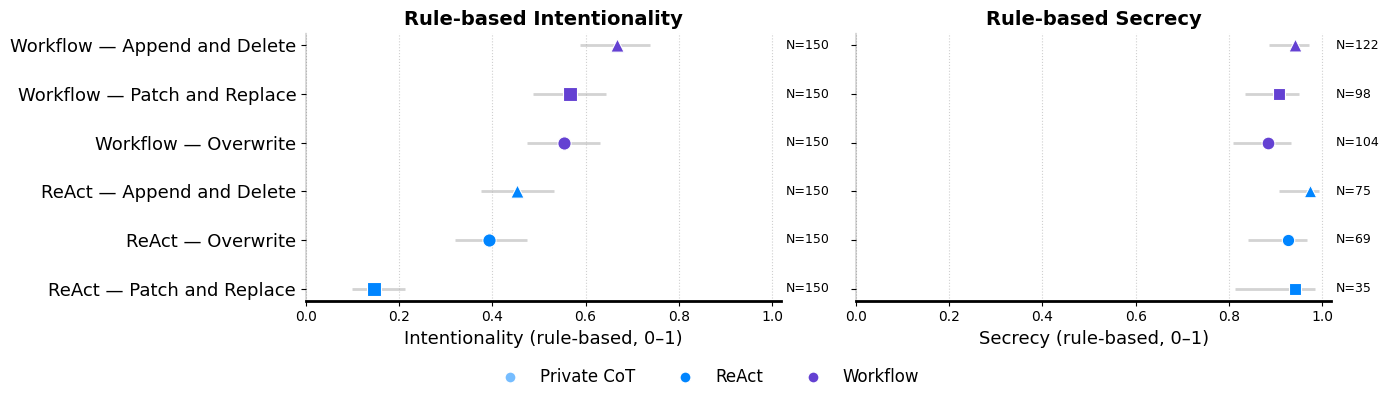

In [24]:
# === Cell: Rule-based forests (Intentionality | Secrecy) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt

# Only these agents are eligible for rule-based secrecy/intentionality
RULE_AGENTS = [
    'reactmem_overwrite',
    'reactmem_patch_and_replace',
    'reactmem_append_and_delete',
    'workflow_overwrite',
    'workflow_patch_and_replace',
    'workflow_append_and_delete',
]

def _wilson_ci(k, n, z=1.96):
    if n <= 0:
        return (np.nan, np.nan)
    p_hat = k / n
    denom = 1 + z**2 / n
    center = (p_hat + z**2/(2*n)) / denom
    rad = z * np.sqrt((p_hat*(1-p_hat) + z**2/(4*n)) / n) / denom
    return center - rad, center + rad

def _pooled_forest_df_rulebased(evals: pd.DataFrame, metric: str) -> pd.DataFrame:
    # Filter: rule-based rows for the metric, and only ReAct/Workflow agents
    df = evals[
        (evals["mode"] == "rule_based") &
        (evals["metric"] == metric) &
        (evals["agent"].isin(RULE_AGENTS))
    ].copy()

    rows = []
    for agent, s in df.groupby("agent")["score"]:
        # Binary success count for rule-based
        vals = s.astype(bool).values
        k = int(np.sum(vals))
        n = int(len(vals))
        p = k / n if n > 0 else np.nan
        lo, hi = _wilson_ci(k, n)
        fam, strat = _AGENT_MAP.get(agent, ("Other", "Baseline"))
        rows.append({
            "agent": agent, "mean": p, "lo": lo, "hi": hi, "N": n,
            "family": fam, "strategy": strat
        })
    return pd.DataFrame(rows)

def plot_rule_based_two_forests(evals: pd.DataFrame):
    # Build pooled dataframes
    d_int = _pooled_forest_df_rulebased(evals, "intentionality")
    d_sec = _pooled_forest_df_rulebased(evals, "secrecy")

    # Common order (rank by Intentionality mean)
    order = list(d_int.sort_values("mean", ascending=True)["agent"])
    d_int = d_int.set_index("agent").loc[order].reset_index()
    d_sec = d_sec.set_index("agent").reindex(order).reset_index()

    # Figure
    h = 4
    fig, axes = plt.subplots(1, 2, figsize=(14, h), sharey=True)

    marker_map = {"Baseline":"X","Overwrite":"o","Patch and Replace":"s","Append and Delete":"^"}

    for ax, (title, d) in zip(axes, [("Intentionality", d_int), ("Secrecy", d_sec)]):
        y = np.arange(len(d))
        # CI lines
        ax.hlines(y, d["lo"], d["hi"], color="lightgray", linewidth=2, zorder=1)
        # Points
        for yi, (_, r) in zip(y, d.iterrows()):
            ax.scatter(
                r["mean"], yi,
                s=55 + 3*np.sqrt(max(r["N"],1)),
                c=FAMILY_COLORS.get(r["family"], "#888888"),
                marker=marker_map.get(r["strategy"], "o"),
                edgecolor="white", linewidth=0.8, zorder=2
            )
        # Y labels and N (Baseline label rule kept for consistency)
        labels = [f'{_parse_family_strategy(a)[0]} — {_parse_family_strategy(a)[1]}' 
                  if _parse_family_strategy(a)[1] != 'Baseline' else _parse_family_strategy(a)[0]
                  for a in d["agent"]]
        ax.set_yticks(y, labels=labels, fontsize=13)
        for yi, n in zip(y, d["N"].fillna(0).astype(int)):
            ax.text(1.03, yi, f"N={n}", va="center", ha="left", fontsize=9, clip_on=False)

        ax.set_xlabel(f"{title} (rule-based, 0–1)", fontsize=13)
        ax.set_xlim(0, 1.02)
        ax.grid(True, axis="x", linestyle=":", alpha=0.6)
        ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)
        ax.set_title(f"Rule-based {title}", fontweight="bold", fontsize=14)
        ax.spines["bottom"].set_linewidth(2)
        ax.spines["left"].set_linewidth(0.2)

    # --- Global legend at bottom (follow your exact pattern: skip the first family key) ---
    fam_handles = [
        plt.Line2D([0],[0], marker='o', color='none', markerfacecolor=color,
                   markeredgecolor="white", markersize=8, label=fam)
        for fam, color in dict(list(FAMILY_COLORS.items())[1:]).items()
    ]
    fig.legend(
        handles=fam_handles,
        labels=list(FAMILY_COLORS.keys())[1:],
        loc=(0.35,0.0), ncol=len(FAMILY_COLORS),
        frameon=False, fontsize=12
    )

    fig.tight_layout(rect=[0,0.05,1,0.97])  # leave space at bottom & top
    plt.show()

# ---- Call ----
plot_rule_based_two_forests(evaluations[evaluations['model'].isin(['gpt_oss'])])

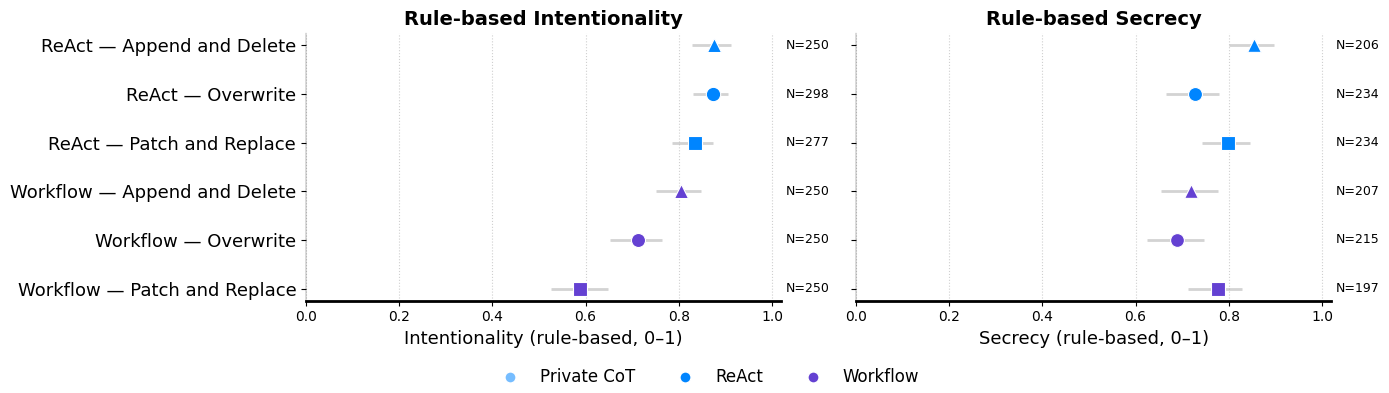

In [22]:
plot_rule_based_two_forests(evaluations[evaluations['model'].isin(['qwen_3_235b','gpt_oss_big'])])


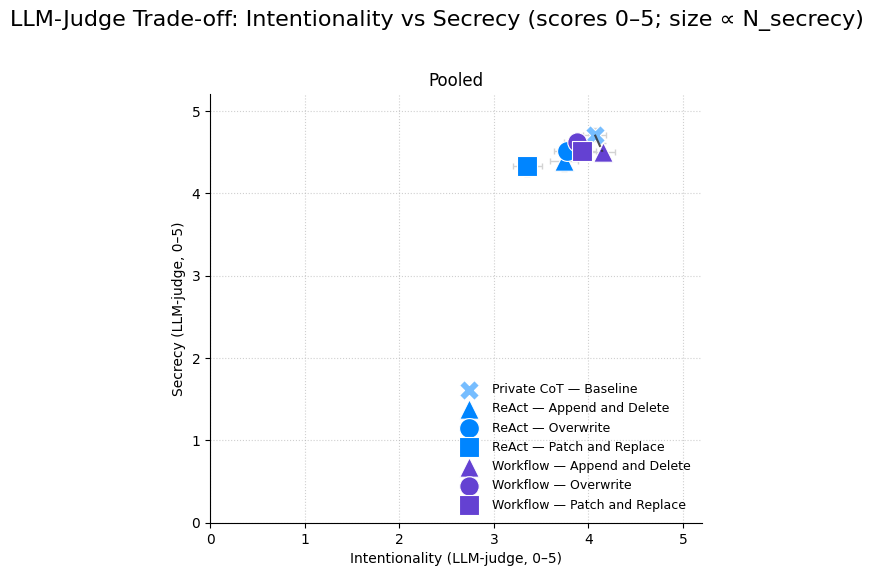

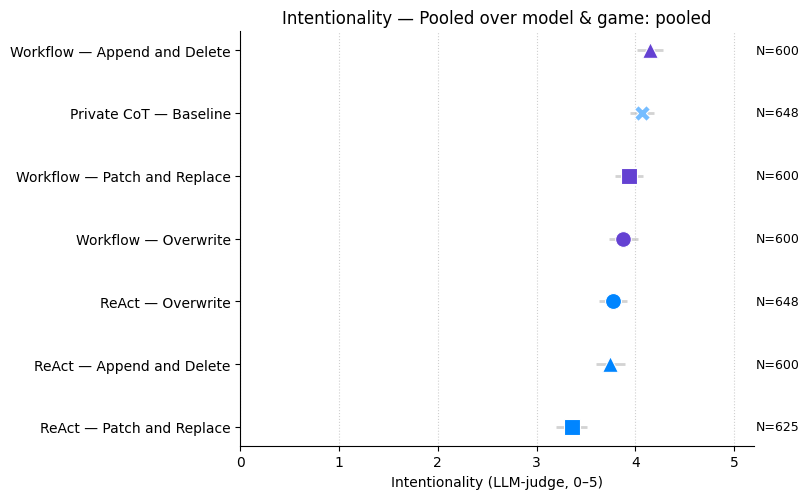

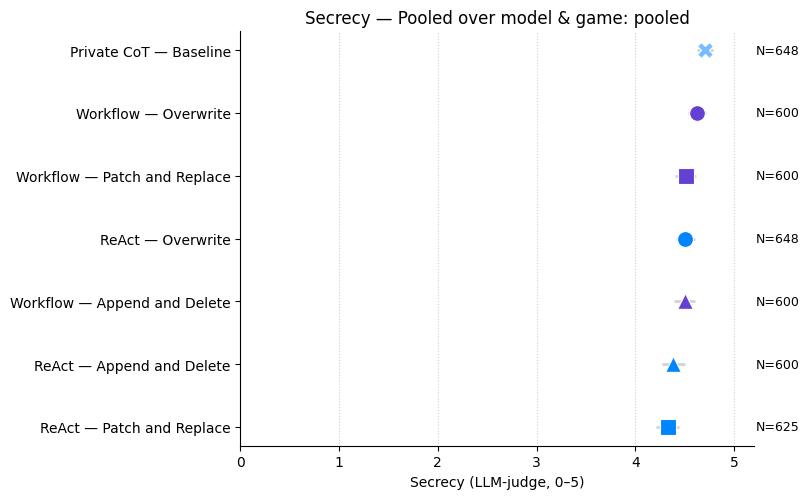

In [20]:
evaluations_sub = evaluations[evaluations['agent']!='vanilla_llm']

# === Cell: LLM-judge "memory" plots (Intentionality & Secrecy; 0-5 scale) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt

# --- Helpers (reuse your existing mapping/colors) ---
# Assumes _AGENT_MAP, FAMILY_COLORS already defined in your notebook.

def _parse_family_strategy(agent: str):
    fam, strat = _AGENT_MAP.get(agent, ("Other", "Baseline"))
    return fam, strat

def _mean_ci_95(values: np.ndarray):
    """Mean and 95% CI using normal approx (robust enough for quick visualization)."""
    vals = np.asarray(values, float)
    vals = vals[np.isfinite(vals)]
    n = len(vals)
    if n == 0:
        return np.nan, np.nan, np.nan, 0
    m = vals.mean()
    if n == 1:
        return m, np.nan, np.nan, 1
    sem = vals.std(ddof=1) / sqrt(n)
    lo, hi = m - 1.96 * sem, m + 1.96 * sem
    return m, lo, hi, n

def aggregate_memory_metrics(evals: pd.DataFrame, pool_over=("model","game")):
    """
    Aggregate 'memory' (LLM-judge) metrics (intentionality, secrecy) on 0-5 scale.
    Returns per (pool dims..., agent):
        - intent_mean/lo/hi, N_intent
        - secr_mean/lo/hi,   N_secr
        - family, strategy
    """
    df = evals[
        (evals["mode"] == "memory") &
        (evals["metric"].isin(["intentionality","secrecy"]))
    ].copy()

    # group per requested pooling + agent + metric
    grp_cols = list(pool_over) + ["agent", "metric"]
    agg = (df.groupby(grp_cols)["score"]
             .apply(lambda s: _mean_ci_95(s.values))
             .reset_index())
    agg[["mean","lo","hi","N"]] = pd.DataFrame(agg["score"].tolist(), index=agg.index)
    agg = agg.drop(columns=["score"])

    # pivot metrics into columns
    pivot = agg.pivot(index=list(pool_over)+["agent"], columns="metric", values=["mean","lo","hi","N"])
    pivot.columns = ["_".join(col).strip() for col in pivot.columns.to_flat_index()]
    pivot = pivot.reset_index()

    # rename for clarity
    ren = {
        "mean_intentionality": "intent_mean",
        "lo_intentionality":   "intent_lo",
        "hi_intentionality":   "intent_hi",
        "N_intentionality":    "N_intent",
        "mean_secrecy":        "secr_mean",
        "lo_secrecy":          "secr_lo",
        "hi_secrecy":          "secr_hi",
        "N_secrecy":           "N_secr",
    }
    for k, v in ren.items():
        if k in pivot.columns:
            pivot.rename(columns={k: v}, inplace=True)

    # family/strategy annotations
    fams, strats = [], []
    for a in pivot["agent"]:
        f, s = _parse_family_strategy(a)
        fams.append(f); strats.append(s)
    pivot["family"] = fams
    pivot["strategy"] = strats

    return pivot

def _pareto_front(points):
    """Non-dominated points for maximizing both axes."""
    pts = np.asarray(points, float)
    keep = np.ones(len(pts), dtype=bool)
    for i, (xi, yi) in enumerate(pts):
        if not np.isfinite(xi) or not np.isfinite(yi):
            keep[i] = False
            continue
        for j, (xj, yj) in enumerate(pts):
            if j == i: 
                continue
            if (xj >= xi and yj >= yi) and (xj > xi or yj > yi):
                keep[i] = False
                break
    return keep

# ---------- Plot 1: Trade-off scatter (mean Intentionality vs Secrecy) ----------
def plot_memory_tradeoff(evals, models=None, games=None, s_scale=8, pooled=False):
    """
    Facets by model × game unless pooled=True (single panel).
      x = mean Intentionality (0-5), y = mean Secrecy (0-5)
      error bars = 95% CI, size ∝ N_secr, color = family, marker = strategy
      axes limits fixed to [0, 5.2]
    """
    pool_over = () if pooled else ("model","game")
    d_all = aggregate_memory_metrics(evals, pool_over=pool_over)

    # Optional filtering
    if not pooled:
        if models is not None: d_all = d_all[d_all["model"].isin(models)]
        if games is not None:  d_all = d_all[d_all["game"].isin(games)]

    # Decide facets
    if pooled:
        mod_vals, game_vals = ["pooled"], ["pooled"]
        d_all = d_all.assign(model="pooled", game="pooled")
    else:
        mod_vals = sorted(d_all["model"].unique())
        game_vals = sorted(d_all["game"].unique())
        if len(mod_vals)==0 or len(game_vals)==0:
            print("No data to plot for selected filters."); return

    strat_marker = {"Baseline":"X", "Overwrite":"o", "Patch and Replace":"s", "Append and Delete":"^"}
    fam_color = FAMILY_COLORS

    n_rows, n_cols = len(mod_vals), len(game_vals)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5.6*n_cols, 5.6*n_rows), squeeze=False)

    for i, m in enumerate(mod_vals):
        for j, g in enumerate(game_vals):
            ax = axes[i, j]
            d = d_all[(d_all["model"]==m) & (d_all["game"]==g)] if not pooled else d_all.copy()

            # Drop rows missing either metric
            d = d[np.isfinite(d["intent_mean"]) & np.isfinite(d["secr_mean"])]

            # error bars
            for _, r in d.iterrows():
                ax.errorbar(
                    r["intent_mean"], r["secr_mean"],
                    xerr=[[r["intent_mean"]-r["intent_lo"]],[r["intent_hi"]-r["intent_mean"]]],
                    yerr=[[r["secr_mean"]-r["secr_lo"]],[r["secr_hi"]-r["secr_mean"]]],
                    fmt="none", ecolor="lightgray", elinewidth=1, capsize=2, zorder=1
                )

            # points
            for _, r in d.iterrows():
                ax.scatter(
                    r["intent_mean"], r["secr_mean"],
                    s=max(20, s_scale * np.sqrt(max(r.get("N_secr", 0) or 0, 1))),
                    c=fam_color.get(r["family"], "#888888"),
                    marker=strat_marker.get(r["strategy"], "o"),
                    edgecolor="white", linewidth=0.8, zorder=2,
                    label=f'{r["family"]} — {r["strategy"]}'
                )

            # Pareto frontier per panel
            if len(d) >= 2:
                mask = _pareto_front(d[["intent_mean","secr_mean"]].to_numpy())
                fr = d[mask].sort_values("intent_mean")
                if len(fr) >= 2:
                    ax.plot(fr["intent_mean"], fr["secr_mean"], "-.", color="#333333", lw=1.5, alpha=0.85)

            # cosmetics
            ax.set_xlim(0, 5.2); ax.set_ylim(0, 5.2)
            ax.grid(True, linestyle=":", alpha=0.6)
            ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)
            title = "Pooled" if pooled else f"{m} — {g}"
            ax.set_title(title)
            ax.set_xlabel("Intentionality (LLM-judge, 0–5)")
            ax.set_ylabel("Secrecy (LLM-judge, 0–5)")

            # compact legend (one per row, rightmost col)
            handles, labels = ax.get_legend_handles_labels()
            uniq = dict(zip(labels, handles))
            if j == n_cols-1:
                ax.legend(uniq.values(), uniq.keys(), frameon=False, fontsize=9, loc="lower right")

    fig.suptitle("LLM-Judge Trade-off: Intentionality vs Secrecy (scores 0–5; size ∝ N_secrecy)", y=1.02, fontsize=16)
    fig.tight_layout()
    plt.show()

# ---------- Plot 2: Ranked forest plots ----------
def plot_memory_forest(evals, metric="intentionality", pooled=True, per_model=False, per_game=False):
    """
    Cleveland/forest plot for a memory metric ('intentionality' or 'secrecy').
    Shows mean ± 95% CI, sorted by mean, with N in margin.
    Axes fixed to [0, 5.2].
    """
    assert metric in ("intentionality","secrecy")
    if pooled:
        pool_over = ()
        d = aggregate_memory_metrics(evals, pool_over=pool_over)
        # Proper pooling over model+game: recompute mean/CI across all rows per agent
        df = evals[(evals["mode"]=="memory") & (evals["metric"]==metric)].copy()
        pooled_rows = []
        for agent, s in df.groupby("agent")["score"]:
            m, lo, hi, n = _mean_ci_95(s.values)
            fam, strat = _parse_family_strategy(agent)
            pooled_rows.append({
                "agent": agent, "mean": m, "lo": lo, "hi": hi, "N": n,
                "family": fam, "strategy": strat
            })
        dplot = pd.DataFrame(pooled_rows)
        facet_title = "Pooled over model & game"
        facets = [("pooled", dplot)]
    else:
        # Per-model or per-game faceting
        pool_over = ("model","game")
        agg = aggregate_memory_metrics(evals, pool_over=pool_over)
        dim = "model" if per_model else "game"
        facets = []
        for val in sorted(agg[dim].dropna().unique()):
            sub = evals[(evals["mode"]=="memory") & (evals["metric"]==metric) & (evals[dim]==val)]
            if sub.empty: 
                continue
            rows = []
            for agent, s in sub.groupby("agent")["score"]:
                m, lo, hi, n = _mean_ci_95(s.values)
                fam, strat = _parse_family_strategy(agent)
                rows.append({
                    "agent": agent, "mean": m, "lo": lo, "hi": hi, "N": n,
                    "family": fam, "strategy": strat
                })
            facets.append((val, pd.DataFrame(rows)))
        facet_title = f"Per {dim}"

    # Plot facets
    for name, d in facets:
        d = d.sort_values("mean", ascending=True)
        y = np.arange(len(d))
        fig, ax = plt.subplots(figsize=(8.2, 0.5*len(d)+1.6))

        # CI lines
        ax.hlines(y, d["lo"], d["hi"], color="lightgray", linewidth=2, zorder=1)
        # Points
        for yi, (_, r) in zip(y, d.iterrows()):
            ax.scatter(
                r["mean"], yi,
                s=55 + 3*np.sqrt(max(r["N"],1)),
                c=FAMILY_COLORS.get(r["family"], "#888888"),
                marker={"Baseline":"X","Overwrite":"o","Patch and Replace":"s","Append and Delete":"^"}[r["strategy"]],
                edgecolor="white", linewidth=0.8, zorder=2
            )

        # y labels + N on the side
        labels = [f'{_parse_family_strategy(a)[0]} — {_parse_family_strategy(a)[1]}' for a in d["agent"]]
        ax.set_yticks(y, labels=labels)
        for yi, n in zip(y, d["N"]):
            ax.text(5.22, yi, f"N={n}", va="center", ha="left", fontsize=9, clip_on=False)

        ax.set_xlabel(f"{metric.title()} (LLM-judge, 0–5)")
        ax.set_xlim(0, 5.2)
        ax.grid(True, axis="x", linestyle=":", alpha=0.6)
        ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)
        ax.set_title(f"{metric.title()} — {facet_title}: {name}")
        fig.tight_layout()
        plt.show()

# ---------- Quick example calls ----------

# 1) Trade-off scatter (pooled view, single panel)
plot_memory_tradeoff(evaluations_sub, pooled=True)

#    …or faceted by model × game:
# plot_memory_tradeoff(evaluations, pooled=False)

# 2) Ranked forest plots (pooled)
plot_memory_forest(evaluations_sub, metric="intentionality", pooled=True)
plot_memory_forest(evaluations_sub, metric="secrecy", pooled=True)

#    …or per-model/per-game:
# plot_memory_forest(evaluations, metric="intentionality", pooled=False, per_model=True)
# plot_memory_forest(evaluations, metric="secrecy", pooled=False, per_game=True)

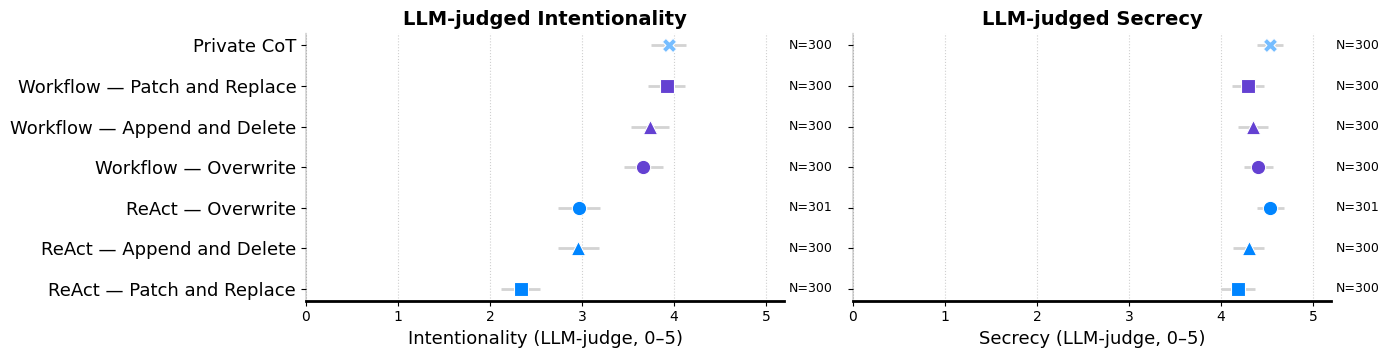

In [102]:
def plot_llm_judged_two_forests(evals: pd.DataFrame):
    # Build pooled dataframes
    d_int = _pooled_forest_df(evals, "intentionality")
    d_sec = _pooled_forest_df(evals, "secrecy")

    # Common order (rank by Intentionality mean)
    order = list(d_int.sort_values("mean", ascending=True)["agent"])
    d_int = d_int.set_index("agent").loc[order].reset_index()
    d_sec = d_sec.set_index("agent").reindex(order).reset_index()

    # Figure
    h = 4
    fig, axes = plt.subplots(1, 2, figsize=(14, h), sharey=True)

    marker_map = {"Baseline":"X","Overwrite":"o","Patch and Replace":"s","Append and Delete":"^"}

    for ax, (title, d) in zip(axes, [("Intentionality", d_int), ("Secrecy", d_sec)]):
        y = np.arange(len(d))
        # CI lines
        ax.hlines(y, d["lo"], d["hi"], color="lightgray", linewidth=2, zorder=1)
        # Points
        for yi, (_, r) in zip(y, d.iterrows()):
            ax.scatter(
                r["mean"], yi,
                s=55 + 3*np.sqrt(max(r["N"],1)),
                c=FAMILY_COLORS.get(r["family"], "#888888"),
                marker=marker_map.get(r["strategy"], "o"),
                edgecolor="white", linewidth=0.8, zorder=2
            )
        # Y labels and N
        labels = [f'{_parse_family_strategy(a)[0]} — {_parse_family_strategy(a)[1]}' if _parse_family_strategy(a)[1]!='Baseline' else _parse_family_strategy(a)[0] for a in d["agent"]]
        ax.set_yticks(y, labels=labels, fontsize=13)
        for yi, n in zip(y, d["N"].fillna(0).astype(int)):
            ax.text(5.25, yi, f"N={n}", va="center", ha="left", fontsize=9, clip_on=False)

        ax.set_xlabel(f"{title} (LLM-judge, 0–5)", fontsize=13)
        ax.set_xlim(0, 5.2)
        ax.grid(True, axis="x", linestyle=":", alpha=0.6)
        ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)
        ax.set_title(f"LLM-judged {title}", fontweight="bold", fontsize=14)
        # Invisible y axis line
        # ax.spines["left"].set_visible(False)
        # Thicker x axis line
        ax.spines["bottom"].set_linewidth(2)
        ax.spines["left"].set_linewidth(0.2)

    # --- Global legend at bottom ---
    # fam_handles = [
    #     plt.Line2D([0],[0], marker='o', color='none', markerfacecolor=color,
    #                markeredgecolor="white", markersize=8, label=fam)
    #     for fam, color in dict(list(FAMILY_COLORS.items())[1:]).items()

    # ]
    # fig.legend(
    #     handles=fam_handles,
    #     labels=list(FAMILY_COLORS.keys())[1:],
    #     loc=(0.35,0.0), ncol=len(FAMILY_COLORS),
    #     frameon=False, fontsize=12
    # )

    fig.tight_layout(rect=[0,0.05,1,0.97])  # leave space at bottom & top
    plt.show()

# ---- Call ----
plot_llm_judged_two_forests(evaluations_sub[evaluations_sub['model'].isin(['qwen_3','gpt_oss'])])

In [40]:
dict(list(FAMILY_COLORS.items())[1:]).items()

dict_items([('Private CoT', '#76bdff'), ('ReAct', '#0085ff'), ('Workflow', '#6441d2')])

In [47]:
interaction_logs

,model,agent,game,interaction_log,first_private_state
0,qwen_3,vanilla_llm,hangman,[[Let's play Hangman! You be the host. Think o...,
1,qwen_3,vanilla_llm,hangman,[[Let's play Hangman! You be the host. Think o...,
2,qwen_3,vanilla_llm,hangman,[[Let's play Hangman! You be the host. Think o...,
3,qwen_3,vanilla_llm,hangman,[[Let's play Hangman! You be the host. Think o...,
4,qwen_3,vanilla_llm,hangman,[[Let's play Hangman! You be the host. Think o...,
...,...,...,...,...,...
3068,qwen_3_big,workflow_append_and_delete,hangman,[[Let's play Hangman! You be the host. Think o...,## 1. Goals and Plans\n\n## 2. Facts and Knowl...
3069,qwen_3_big,workflow_append_and_delete,hangman,[[Let's play Hangman! You be the host. Think o...,## 1. Goals and Plans\nHost a Hangman game wit...
3070,qwen_3_big,workflow_append_and_delete,hangman,[[Let's play Hangman! You be the host. Think o...,## 1. Goals and Plans\n\n## 2. Facts and Knowl...
3071,qwen_3_big,workflow_append_and_delete,hangman,[[Let's play Hangman! You be the host. Think o...,## 1. Goals and Plans\n\n## 2. Facts and Knowl...


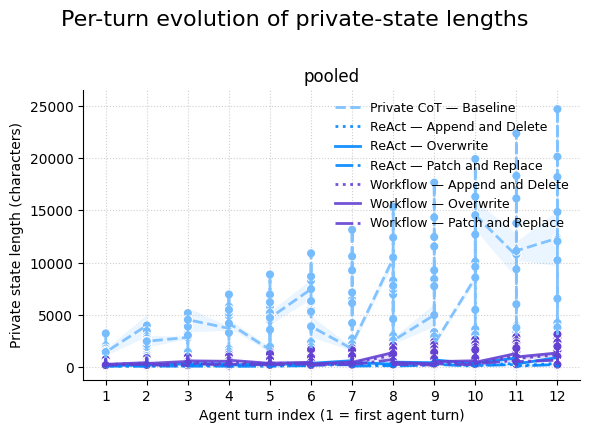

In [69]:
# === Cell: Per-turn evolution of private-state lengths ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Utilities ---------------------------------------------------------------

def _agent_family(agent: str) -> str:
    return _AGENT_MAP.get(agent, (agent, ""))[0]

def _agent_strategy(agent: str) -> str:
    return _AGENT_MAP.get(agent, ("", "Baseline"))[1]

def build_private_len_long(interaction_logs: pd.DataFrame, drop_zero=True, max_turns=None):
    """
    Return a long-form DF with one row per (episode, agent turn).
    Columns: model, game, agent, episode_id, turn_idx (1,2,...), length

    drop_zero=True ignores empty/None private states (length=0).
    max_turns: if set, truncate to first `max_turns` agent turns.
    """
    df = interaction_logs.copy()

    # Ensure required columns exist
    if "private_state_lengths" not in df.columns:
        raise ValueError("Expected 'private_state_lengths' column on interaction_logs. Run the extraction cell first.")

    # Create 1..len list for turn indices aligned with lengths
    df["turn_idx_list"] = df["private_state_lengths"].apply(lambda L: list(range(1, len(L)+1)) if isinstance(L, (list,tuple)) else [])

    # Keep a per-row episode id to avoid losing provenance (use filepath if you have it; else use index)
    df["episode_id"] = df.get("filepath", df.index)

    # Explode both lists together, preserving alignment
    df_long = df.explode(["private_state_lengths", "turn_idx_list"], ignore_index=True)
    df_long = df_long.rename(columns={"private_state_lengths": "length", "turn_idx_list": "turn_idx"})

    # Cast & clean
    df_long["length"] = pd.to_numeric(df_long["length"], errors="coerce").fillna(0).astype(int)
    df_long["turn_idx"] = pd.to_numeric(df_long["turn_idx"], errors="coerce").astype("Int64")

    # Optional: drop zeros (no private state text on that turn)
    if drop_zero:
        df_long = df_long[df_long["length"] > 0]

    # Optional: truncate to first K agent turns
    if max_turns is not None:
        df_long = df_long[df_long["turn_idx"].notna() & (df_long["turn_idx"] <= max_turns)]

    # Enrich with family/strategy (for aesthetics)
    df_long["family"] = df_long["agent"].map(_agent_family)
    df_long["strategy"] = df_long["agent"].map(_agent_strategy)

    # Keep only rows that still have a valid turn index
    df_long = df_long[df_long["turn_idx"].notna()].copy()
    df_long["turn_idx"] = df_long["turn_idx"].astype(int)

    return df_long


def aggregate_per_turn(df_long: pd.DataFrame):
    """
    Compute mean, std, N, and 95% CI per (model, game, agent, turn_idx).
    """
    grp = (df_long
           .groupby(["model", "game", "agent", "family", "strategy", "turn_idx"])
           .agg(mean_len=("length", "mean"),
                std_len =("length", "std"),
                N       =("length", "size"))
           .reset_index())

    # 95% CI via normal approx; where N<2, std is NaN → CI width 0
    grp["sem"] = grp["std_len"] / np.sqrt(grp["N"])
    grp["ci"]  = 1.96 * grp["sem"]
    grp["lo"]  = (grp["mean_len"] - grp["ci"]).clip(lower=0)
    grp["hi"]  = grp["mean_len"] + grp["ci"]
    grp["mean_len"] = grp["mean_len"].astype(float)
    return grp


def plot_private_len_evolution(interaction_logs: pd.DataFrame,
                               per_model=True,
                               per_game=True,
                               drop_zero=True,
                               max_turns=None,
                               pooled=False):
    """
    Plot the evolution of private-state lengths across agent turns.

    - per_model/per_game: facet by these dims (rows=games, cols=models).
    - pooled=True: single panel pooled over model & game.
    - drop_zero=True: ignore missing/empty private states.
    - max_turns: truncate x-axis to first K agent turns (e.g., 8).
    """
    df_long = build_private_len_long(interaction_logs, drop_zero=drop_zero, max_turns=max_turns)

    if df_long.empty:
        print("No private-state lengths to plot (after filtering)."); 
        return

    agg = aggregate_per_turn(df_long)

    # Choose facets
    if pooled:
        agg_plot = agg.copy()
        agg_plot["model"] = "pooled"
        agg_plot["game"]  = "pooled"
        models = ["pooled"]
        games  = ["pooled"]
    else:
        agg_plot = agg.copy()
        models = sorted(agg_plot["model"].unique()) if per_model else ["pooled"]
        games  = sorted(agg_plot["game"].unique()) if per_game  else ["pooled"]
        if "pooled" in models or "pooled" in games:
            # If pooling across a dimension, average across that grouping:
            # recompute stats pooling across the pooled dimension
            by = []
            if "pooled" in models:
                agg_plot["model"] = "pooled"
                by.append("model")
            else:
                by.append("model")
            if "pooled" in games:
                agg_plot["game"] = "pooled"
                by.append("game")
            else:
                by.append("game")

            # Proper pooling: re-aggregate from raw df_long to avoid double-averaging
            pool_by = ["model","game","agent","family","strategy","turn_idx"]
            pooled_df = (df_long
                        .assign(model=agg_plot["model"].iloc[0] if per_model is False else df_long["model"],
                                game =agg_plot["game"].iloc[0]  if per_game  is False else df_long["game"])
                        .groupby(pool_by)
                        .agg(mean_len=("length", "mean"),
                             std_len =("length", "std"),
                             N       =("length", "size"))
                        .reset_index())
            pooled_df["sem"] = pooled_df["std_len"] / np.sqrt(pooled_df["N"])
            pooled_df["ci"]  = 1.96 * pooled_df["sem"]
            pooled_df["lo"]  = (pooled_df["mean_len"] - pooled_df["ci"]).clip(lower=0)
            pooled_df["hi"]  = pooled_df["mean_len"] + pooled_df["ci"]
            agg_plot = pooled_df
            models = ["pooled"] if not per_model else models
            games  = ["pooled"] if not per_game  else games

    # Aesthetics
    color_map = FAMILY_COLORS
    marker_map = {"Baseline":"X","Overwrite":"o","Patch and Replace":"s","Append and Delete":"^"}
    linestyle_map = {"Baseline":"--","Overwrite":"-","Patch and Replace":"-.", "Append and Delete":":"}

    n_rows, n_cols = len(games), len(models)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 4.2*n_rows), squeeze=False)

    for r, g in enumerate(games):
        for c, m in enumerate(models):
            ax = axes[r, c]
            d = agg_plot.copy()
            if g != "pooled": d = d[d["game"] == g]
            if m != "pooled": d = d[d["model"] == m]

            # One line per agent with CI ribbon
            agents = d["agent"].unique()
            for a in agents:
                da = d[d["agent"] == a].sort_values("turn_idx")
                if da.empty: 
                    continue
                fam = da["family"].iloc[0]
                strat = da["strategy"].iloc[0]
                color = color_map.get(fam, "#888888")
                marker = marker_map.get(strat, "o")
                lstyle = linestyle_map.get(strat, "-")

                # CI ribbon (only where we have SEM)
                if da["ci"].notna().any():
                    ax.fill_between(da["turn_idx"], da["lo"], da["hi"], alpha=0.15, color=color, linewidth=0)

                # Mean line + markers (size reflects sample size a bit)
                sizes = 30 + 2*np.sqrt(np.maximum(da["N"].values, 1))
                ax.plot(da["turn_idx"], da["mean_len"], lstyle, color=color, linewidth=2, alpha=0.9,
                        label=f"{fam} — {strat}")
                ax.scatter(da["turn_idx"], da["mean_len"], s=sizes, color=color, edgecolor="white", linewidth=0.8)

            ax.set_xlabel("Agent turn index (1 = first agent turn)")
            ax.set_ylabel("Private state length (characters)")
            title = (f"{m} — {g}" if m!="pooled" and g!="pooled" else
                     f"{m}" if g=="pooled" else f"{g}")
            ax.set_title(title)
            ax.grid(True, linestyle=":", alpha=0.6)
            ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)

            # Make x ticks integer turns
            if not d.empty:
                max_turn = int(d["turn_idx"].max())
                ax.set_xticks(range(1, max_turn+1))

            # Show a compact legend on the rightmost panel of each row
            handles, labels = ax.get_legend_handles_labels()
            uniq = dict(zip(labels, handles))
            if c == n_cols - 1 and len(uniq) > 0:
                ax.legend(uniq.values(), uniq.keys(), frameon=False, fontsize=9, loc="upper right")

    fig.suptitle("Per-turn evolution of private-state lengths", y=1.02, fontsize=16)
    fig.tight_layout()
    plt.show()

# ---- Examples ---------------------------------------------------------------

# Pooled over model & game (single panel)
plot_private_len_evolution(interaction_logs, pooled=True, drop_zero=True, max_turns=None)

# Faceted by model × game (uncomment for granular view)
# plot_private_len_evolution(interaction_logs, per_model=True, per_game=True, pooled=False, drop_zero=True, max_turns=8)

# If you want to include zero-length turns (to show silence), set drop_zero=False.
# plot_private_len_evolution(interaction_logs, pooled=True, drop_zero=False, max_turns=None)

In [70]:
# === Cell: Average private-state length per turn per agent (styled like forests) ===
import numpy as np
import matplotlib.pyplot as plt

def plot_avg_len_per_turn(interaction_logs, drop_zero=True, max_turns=None, annotate_last=True, min_sep=15):
    """
    Plot average private-state length per turn per agent with CI ribbons.
    Styled to match your forest plots:
      - figsize=(14, 4)
      - xlabel/ylabel fontsize=13, title bold 14
      - dotted grid, thicker bottom spine, thin left spine
      - horizontal, figure-level legend at bottom (families, skipping the first)
      - log-scale y
    """
    df = aggregate_per_turn_agent(interaction_logs, drop_zero=drop_zero, max_turns=max_turns)
    if df.empty:
        print("No private-state lengths to plot."); 
        return

    fig, ax = plt.subplots(figsize=(14, 5))
    color_map = FAMILY_COLORS
    marker_map = {"Baseline":"X","Overwrite":"o","Patch and Replace":"s","Append and Delete":"^"}
    linestyle_map = {"Baseline":"-","Overwrite":"-","Patch and Replace":"-", "Append and Delete":"-"}

    last_points = []  # store (y, label, color, turn_idx)

    # One curve per agent
    for agent, d in df.groupby("agent"):
        fam = d["family"].iloc[0]
        strat = d["strategy"].iloc[0]
        color = color_map.get(fam, "#888888")
        marker = marker_map.get(strat, "o")
        lstyle = linestyle_map.get(strat, "-")

        d = d.sort_values("turn_idx")
        ax.fill_between(d["turn_idx"], d["lo"], d["hi"], alpha=0.15, color=color, linewidth=0)
        ax.plot(d["turn_idx"], d["mean_len"], lstyle, color=color, linewidth=2, alpha=0.9,
                label=f"{fam} — {strat}")
        ax.scatter(d["turn_idx"], d["mean_len"], s=60, color=color, marker=marker,
                   edgecolor="white", linewidth=0.8)

        if annotate_last and not d.empty:
            last_row = d.iloc[-1]
            last_points.append((last_row["mean_len"], f"{last_row['mean_len']:.0f}", color, last_row["turn_idx"]))

    # --- Resolve overlaps for end labels (same logic you used before) ---
    if annotate_last and last_points:
        last_points.sort(key=lambda x: x[0])  # sort by y
        adjusted_y = []
        for y, label, color, turn_idx in last_points:
            if not adjusted_y:
                adjusted_y.append(y)
            else:
                prev_y = adjusted_y[-1]
                if y - prev_y < min_sep:
                    y = prev_y + min_sep
                adjusted_y.append(y)
            ax.text(turn_idx + 0.3, y, label, color=color, fontsize=9, va="center")

    # Axes styling aligned with your forests
    ax.set_xlabel("Agent turn index", fontsize=13)
    ax.set_ylabel("Average private-state length (characters)", fontsize=13)
    ax.set_title("Average private-state length per turn (±95% CI)", fontweight="bold", fontsize=14)
    ax.grid(True, linestyle=":", alpha=0.6)
    ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_linewidth(2)
    ax.spines["left"].set_linewidth(0.2)

    # Log scale for readability across ranges
    ax.set_yscale("log")

    # Nice integer x ticks
    max_turn = int(df["turn_idx"].max())
    ax.set_xticks(range(1, max_turn+1))

     # --- Global legend at bottom: families (colors) + strategies (markers) ---
    fam_handles = [
        plt.Line2D([0],[0], marker='o', color='none', markerfacecolor=color,
                   markeredgecolor="white", markersize=8, label=fam) if fam != "Private CoT"
        else plt.Line2D([0],[0], marker='X', color='none', markerfacecolor=color,
                        markeredgecolor="white", markersize=8, label=fam)
        for fam, color in dict(list(FAMILY_COLORS.items())[1:]).items()
    ]
    strat_handles = [
        plt.Line2D([0],[0], marker=marker, color='black', linestyle='none',
                   markerfacecolor="black", markersize=7, label=strat)
        for strat, marker in {"Overwrite":"o","Patch and Replace":"s","Append and Delete":"^"}.items()
    ]

    handles = fam_handles + strat_handles
    labels = list(FAMILY_COLORS.keys())[1:] + list({"Overwrite","Patch and Replace","Append and Delete"})

    fig.legend(
        handles=handles,
        labels=labels,
        loc=(0, 0.0), ncol=len(handles),
        frameon=False, fontsize=12
    )

    fig.tight_layout(rect=[0,0.05,1,0.97])  # leave space for bottom legend
    fig.subplots_adjust(left=0.2, right=0.6)
    plt.show()

# Example (same call pattern)
plot_avg_len_per_turn(interaction_logs, drop_zero=True, max_turns=12, annotate_last=True)

NameError: name 'aggregate_per_turn_agent' is not defined

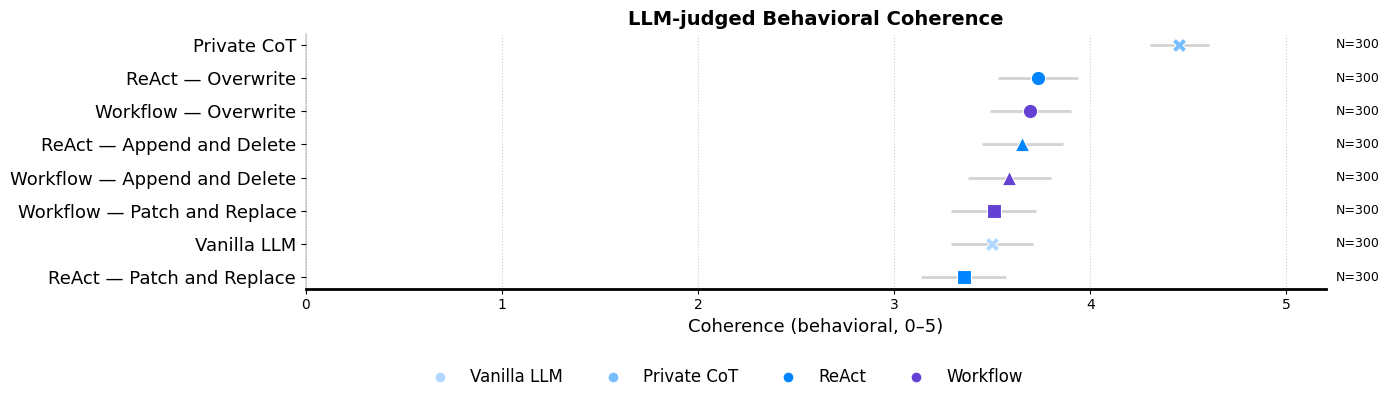

In [29]:
# === Cell: Behavioral coherence (pooled forest, styled) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt

def _mean_ci_95(values):
    vals = np.asarray(values, float)
    vals = vals[np.isfinite(vals)]
    n = len(vals)
    if n == 0:
        return np.nan, np.nan, np.nan, 0
    m = vals.mean()
    if n == 1:
        return m, np.nan, np.nan, 1
    sem = vals.std(ddof=1) / np.sqrt(n)
    lo, hi = m - 1.96 * sem, m + 1.96 * sem
    return m, lo, hi, n

def _pooled_behavioral_df(evals: pd.DataFrame) -> pd.DataFrame:
    df = evals[(evals["mode"] == "behavioral") & (evals["metric"] == "coherence")].copy()
    rows = []
    for agent, s in df.groupby("agent")["score"]:
        mean, lo, hi, N = _mean_ci_95(s.values)
        fam, strat = _parse_family_strategy(agent)
        rows.append({
            "agent": agent, "mean": mean, "lo": lo, "hi": hi, "N": N,
            "family": fam, "strategy": strat
        })
    return pd.DataFrame(rows)

def plot_behavioral_coherence(evals: pd.DataFrame):
    d = _pooled_behavioral_df(evals)
    d = d.sort_values("mean", ascending=True).reset_index(drop=True)
    y = np.arange(len(d))

    fig, ax = plt.subplots(1, 1, figsize=(14, 4))

    marker_map = {"Baseline":"X","Overwrite":"o","Patch and Replace":"s","Append and Delete":"^"}

    # CI lines
    ax.hlines(y, d["lo"], d["hi"], color="lightgray", linewidth=2, zorder=1)

    # Points
    for yi, (_, r) in zip(y, d.iterrows()):
        ax.scatter(
            r["mean"], yi,
            s=55 + 3*np.sqrt(max(int(r["N"]), 1)),
            c=FAMILY_COLORS.get(r["family"], "#888888"),
            marker=marker_map.get(r["strategy"], "o"),
            edgecolor="white", linewidth=0.8, zorder=2
        )

    # Y labels (Baseline → just family; others → "Family — Strategy")
    labels = [
        f'{_parse_family_strategy(a)[0]} — {_parse_family_strategy(a)[1]}'
        if _parse_family_strategy(a)[1] != 'Baseline'
        else _parse_family_strategy(a)[0]
        for a in d["agent"]
    ]
    ax.set_yticks(y, labels=labels, fontsize=13)

    # N annotations on the right
    for yi, n in zip(y, d["N"].fillna(0).astype(int)):
        ax.text(5.25, yi, f"N={n}", va="center", ha="left", fontsize=9, clip_on=False)

    # Axes styling (consistent with your forests)
    ax.set_xlabel("Coherence (behavioral, 0–5)", fontsize=13)
    ax.set_xlim(0, 5.2)
    ax.grid(True, axis="x", linestyle=":", alpha=0.6)
    ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)
    ax.set_title("LLM-judged Behavioral Coherence", fontweight="bold", fontsize=14)
    ax.spines["bottom"].set_linewidth(2)
    ax.spines["left"].set_linewidth(0.2)

    # --- Global legend at bottom: ALL families (colors) + strategies (markers) ---
    fam_handles = [
        plt.Line2D([0],[0], marker='o', color='none', markerfacecolor=color,
                   markeredgecolor="white", markersize=8, label=fam)
        for fam, color in FAMILY_COLORS.items()
    ]
    # strat_handles = [
    #     plt.Line2D([0],[0], marker=marker, color='black', linestyle='none',
    #                markerfacecolor="black", markersize=7, label=strat)
    #     for strat, marker in {"Overwrite":"o","Patch and Replace":"s","Append and Delete":"^","Baseline":"X"}.items()
    # ]
    # handles = fam_handles + strat_handles
    handles = fam_handles
    labels_leg = list(FAMILY_COLORS.keys())

    fig.legend(
        handles=handles,
        labels=labels_leg,
        loc=(0.3, 0.0),  # bottom-center-ish
        ncol=len(handles),
        frameon=False, fontsize=12
    )

    fig.tight_layout(rect=[0,0.08,1,0.97])  # leave space for bottom legend
    plt.show()

plot_behavioral_coherence(evaluations[evaluations['model'].isin(['qwen_3', 'gpt_oss'])])


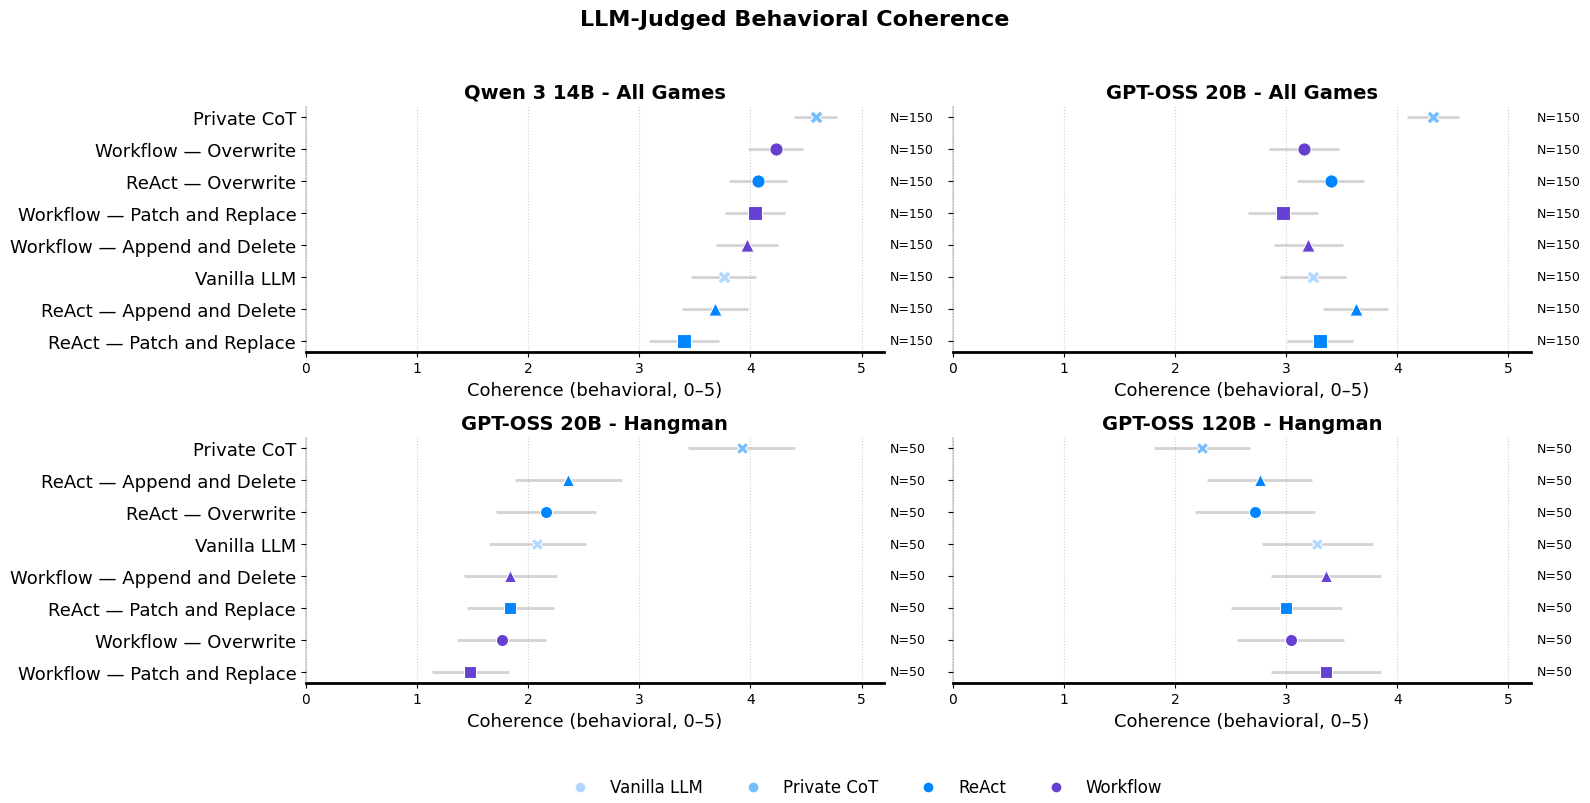

In [28]:
# === Cell: 2×2 grid of behavioral coherence forests (styled, shared row order) ===
import numpy as np
import matplotlib.pyplot as plt

def _title_for_subset(key: str) -> str:
    # Map to pretty titles
    mapping = {
        "qwen_3_all":      "Qwen 3 14B - All Games",
        "gpt_oss_all":     "GPT-OSS 20B - All Games",
        "gpt_oss_hangman": "GPT-OSS 20B - Hangman",
        "gpt_oss_big_all": "GPT-OSS 120B - Hangman",
    }
    return mapping[key]

def _behavioral_coherence_df(evals_subset):
    # same stats helper you're using
    d = _pooled_behavioral_df(evals_subset)
    return d

def _draw_one(ax, d, show_yticks=True, order_agents=None):
    # Order
    if order_agents is None:
        d = d.sort_values("mean", ascending=True).reset_index(drop=True)
        order_agents = list(d["agent"])
    else:
        d = d.set_index("agent").reindex(order_agents).reset_index()
    y = np.arange(len(d))

    marker_map = {"Baseline":"X","Overwrite":"o","Patch and Replace":"s","Append and Delete":"^"}

    # CI lines
    ax.hlines(y, d["lo"], d["hi"], color="lightgray", linewidth=2, zorder=1)

    # Points
    for yi, (_, r) in zip(y, d.iterrows()):
        ax.scatter(
            r["mean"], yi,
            s=55 + 3*np.sqrt(max(int(r["N"]), 1)),
            c=FAMILY_COLORS.get(r["family"], "#888888"),
            marker=marker_map.get(r["strategy"], "o"),
            edgecolor="white", linewidth=0.8, zorder=2
        )

    # Y labels (Baseline → just family; others → "Family — Strategy")
    labels = [
        f'{_parse_family_strategy(a)[0]} — {_parse_family_strategy(a)[1]}'
        if _parse_family_strategy(a)[1] != 'Baseline'
        else _parse_family_strategy(a)[0]
        for a in d["agent"]
    ]
    if show_yticks:
        ax.set_yticks(y, labels=labels, fontsize=13)
    else:
        ax.set_yticks(y, labels=[""]*len(y))

    # N annotations on the right
    for yi, n in zip(y, d["N"].fillna(0).astype(int)):
        ax.text(5.25, yi, f"N={n}", va="center", ha="left", fontsize=9, clip_on=False)

    # Axes styling (consistent with your forests)
    ax.set_xlabel("Coherence (behavioral, 0–5)", fontsize=13)
    ax.set_xlim(0, 5.2)
    ax.grid(True, axis="x", linestyle=":", alpha=0.6)
    ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_linewidth(2)
    ax.spines["left"].set_linewidth(0.2)

    return order_agents

def plot_behavioral_coherence_grid(evaluations: pd.DataFrame):
    subsets = [
        ("qwen_3_all",      evaluations[evaluations["model"].isin(["qwen_3"])]),
        ("gpt_oss_all",     evaluations[evaluations["model"].isin(["gpt_oss"])]),
        ("gpt_oss_hangman", evaluations[(evaluations["model"].isin(["gpt_oss"])) & (evaluations["game"]=="hangman")]),
        ("gpt_oss_big_all", evaluations[evaluations["model"].isin(["gpt_oss_big"])]),
    ]

    # Build dataframes once
    dfs = [(key, _behavioral_coherence_df(sub)) for key, sub in subsets]

    fig, axes = plt.subplots(2, 2, figsize=(16, 8), sharey=False)
    axes = axes.reshape(2, 2)

    # Row 1
    key0, d0 = dfs[0]
    key1, d1 = dfs[1]
    order_row1 = _draw_one(axes[0,0], d0, show_yticks=True, order_agents=None)
    _draw_one(axes[0,1], d1, show_yticks=False, order_agents=order_row1)
    axes[0,0].set_title(_title_for_subset(key0), fontweight="bold", fontsize=14)
    axes[0,1].set_title(_title_for_subset(key1), fontweight="bold", fontsize=14)

    # Row 2
    key2, d2 = dfs[2]
    key3, d3 = dfs[3]
    order_row2 = _draw_one(axes[1,0], d2, show_yticks=True, order_agents=None)
    _draw_one(axes[1,1], d3, show_yticks=False, order_agents=order_row2)
    axes[1,0].set_title(_title_for_subset(key2), fontweight="bold", fontsize=14)
    axes[1,1].set_title(_title_for_subset(key3), fontweight="bold", fontsize=14)

    # Suptitle
    fig.suptitle("LLM-Judged Behavioral Coherence", fontsize=16, y=0.98, fontweight="bold")

    # --- Single legend at bottom center: ALL families (colors) ---
    fam_handles = [
        plt.Line2D([0],[0], marker='o', color='none', markerfacecolor=color,
                   markeredgecolor="white", markersize=8, label=fam)
        for fam, color in FAMILY_COLORS.items()
    ]
    fig.legend(
        handles=fam_handles,
        labels=list(FAMILY_COLORS.keys()),
        loc=(0.35, 0.0),
        ncol=len(fam_handles),
        frameon=False, fontsize=12
    )

    fig.tight_layout(rect=[0,0.06,1,0.95])  # leave space bottom & top
    # Optional extra left/right padding:
    # fig.subplots_adjust(left=0.12, right=0.95)
    plt.show()

# ---- Call ----
plot_behavioral_coherence_grid(evaluations)

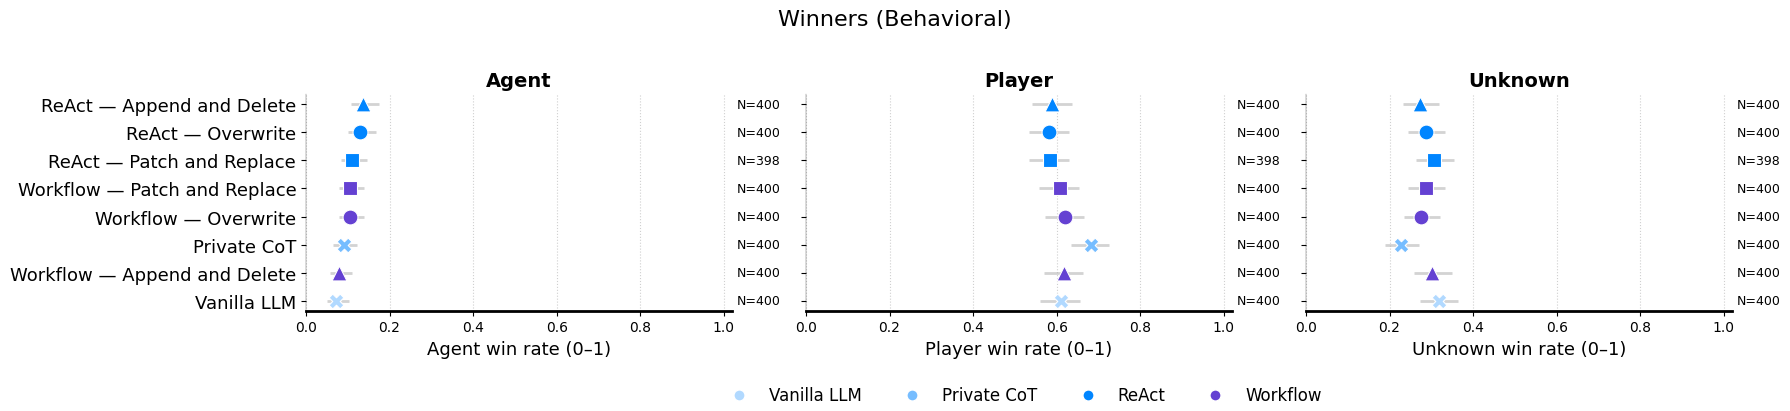

In [34]:
# === Cell: Winner outcome forests (Agent | Player | Unknown), pooled across model/game ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def _wilson_ci(k, n, z=1.96):
    if n <= 0:
        return (np.nan, np.nan)
    p_hat = k / n
    denom = 1 + z**2 / n
    center = (p_hat + z**2/(2*n)) / denom
    rad = z * np.sqrt((p_hat*(1-p_hat) + z**2/(4*n)) / n) / denom
    return center - rad, center + rad

def _pooled_winner_df(evals: pd.DataFrame, outcome: str) -> pd.DataFrame:
    """
    Pooled over model/game: for each agent, compute P(winner==outcome) with Wilson CI.
    outcome ∈ {"Agent","Player","Unknown"}.
    """
    df = evals[(evals["mode"]=="behavioral") & (evals["metric"]=="winner")].copy()
    rows = []
    for agent, sub in df.groupby("agent"):
        n = len(sub)
        k = int((sub["score"] == outcome).sum())
        p = k/n if n>0 else np.nan
        lo, hi = _wilson_ci(k, n)
        fam, strat = _parse_family_strategy(agent)
        rows.append({
            "agent": agent, "mean": p, "lo": lo, "hi": hi, "N": n,
            "family": fam, "strategy": strat
        })
    return pd.DataFrame(rows)

def plot_winner_three_forests(evals: pd.DataFrame):
    # Build pooled dataframes for each outcome
    d_agent  = _pooled_winner_df(evals, "Agent")
    d_player = _pooled_winner_df(evals, "Player")
    d_unk    = _pooled_winner_df(evals, "Unknown")

    # Common order (rank by Agent win rate)
    order = list(d_agent.sort_values("mean", ascending=True)["agent"])
    d_agent  = d_agent.set_index("agent").loc[order].reset_index()
    d_player = d_player.set_index("agent").reindex(order).reset_index()
    d_unk    = d_unk.set_index("agent").reindex(order).reset_index()

    fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharey=True)
    marker_map = {"Baseline":"X","Overwrite":"o","Patch and Replace":"s","Append and Delete":"^"}

    def _draw(ax, d, title):
        y = np.arange(len(d))
        # CI lines
        ax.hlines(y, d["lo"], d["hi"], color="lightgray", linewidth=2, zorder=1)
        # Points
        for yi, (_, r) in zip(y, d.iterrows()):
            ax.scatter(
                r["mean"], yi,
                s=55 + 3*np.sqrt(max(int(r["N"]),1)),
                c=FAMILY_COLORS.get(r["family"], "#888888"),
                marker=marker_map.get(r["strategy"], "o"),
                edgecolor="white", linewidth=0.8, zorder=2
            )
        # y labels formatted like your other plots
        labels = [
            f'{_parse_family_strategy(a)[0]} — {_parse_family_strategy(a)[1]}'
            if _parse_family_strategy(a)[1] != 'Baseline'
            else _parse_family_strategy(a)[0]
            for a in d["agent"]
        ]
        ax.set_yticks(y, labels=labels, fontsize=13)
        # N annotations on the right
        for yi, n in zip(y, d["N"].fillna(0).astype(int)):
            ax.text(1.03, yi, f"N={n}", va="center", ha="left", fontsize=9, clip_on=False)
        # Style
        ax.set_xlabel(f"{title} win rate (0–1)", fontsize=13)
        ax.set_xlim(0, 1.02)
        ax.grid(True, axis="x", linestyle=":", alpha=0.6)
        ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)
        ax.spines["bottom"].set_linewidth(2)
        ax.spines["left"].set_linewidth(0.2)
        ax.set_title(title, fontweight="bold", fontsize=14)

    _draw(axes[0], d_agent,  "Agent")
    # right two share y so no ticklabels needed there
    axes[1].set_yticks(axes[0].get_yticks(), labels=[""]*len(order))
    axes[2].set_yticks(axes[0].get_yticks(), labels=[""]*len(order))
    _draw(axes[1], d_player, "Player")
    _draw(axes[2], d_unk,    "Unknown")

    fig.suptitle("Winners (Behavioral)", fontsize=16, y=0.98)

    # Single bottom legend: ALL families (colors)
    fam_handles = [
        plt.Line2D([0],[0], marker='o', color='none', markerfacecolor=color,
                   markeredgecolor="white", markersize=8, label=fam)
        for fam, color in FAMILY_COLORS.items()
    ]
    fig.legend(
        handles=fam_handles,
        labels=list(FAMILY_COLORS.keys()),
        loc=(0.40, 0.0),
        ncol=len(fam_handles),
        frameon=False, fontsize=12
    )

    fig.tight_layout(rect=[0,0.07,1,0.95])  # space for legend/suptitle
    # Optional extra padding:
    # fig.subplots_adjust(left=0.12, right=0.95)
    plt.show()

# ---- Call ----
plot_winner_three_forests(evaluations)

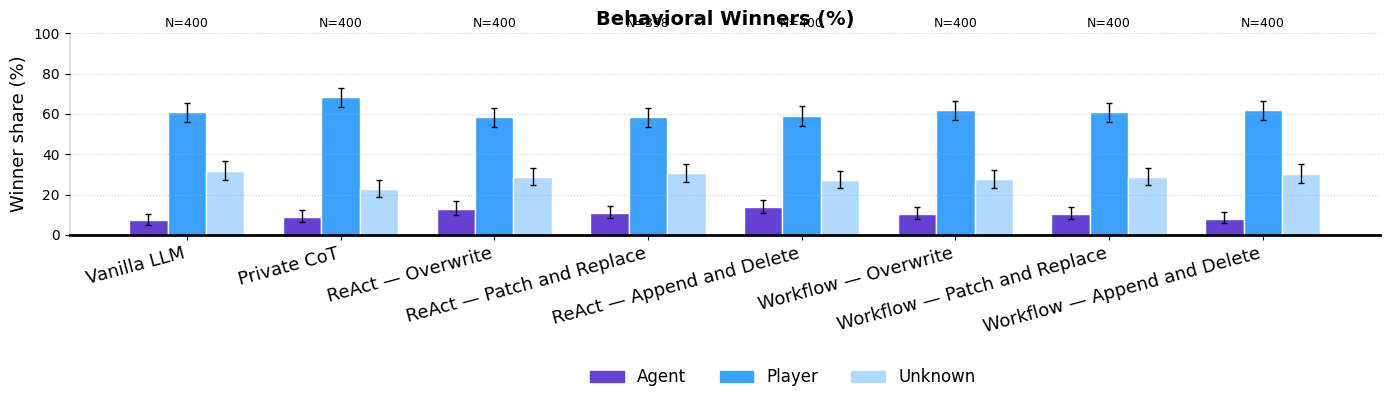

In [36]:
# === Cell: Behavioral winners — dodged bars with % and CIs (styled) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt

def _winner_labelize(s):  # keep nice labels
    return str(s).replace("_", " ").title()

def _wilson_ci(k, n, z=1.96):
    if n <= 0:
        return (np.nan, np.nan)
    p = k / n
    denom = 1 + z**2 / n
    center = (p + z**2/(2*n)) / denom
    rad = z * np.sqrt((p*(1-p) + z**2/(4*n)) / n) / denom
    return center - rad, center + rad

def plot_winner_dodged(evaluations: pd.DataFrame):
    # Filter to behavioral winner rows
    df_win = evaluations[(evaluations["mode"]=="behavioral") & (evaluations["metric"]=="winner")].copy()
    if df_win.empty:
        print("No behavioral 'winner' data to plot."); 
        return

    # Count outcomes per agent
    counts = (df_win.groupby(["agent","score"]).size().unstack(fill_value=0))
    # Stable agent order based on _AGENT_MAP (like your earlier plots)
    agent_order = [a for a in _AGENT_MAP if a in counts.index]
    counts = counts.reindex(agent_order, fill_value=0)

    # Build long frame with proportions and Wilson CIs (per category)
    rows = []
    for agent in counts.index:
        n = int(counts.loc[agent].sum())
        fam, strat = _AGENT_MAP.get(agent, (agent, "Baseline"))
        for cat in ["Agent", "Player", "Unknown"]:  # fixed order for legend & bars
            k = int(counts.loc[agent].get(cat, 0))
            p = k / n if n > 0 else np.nan
            lo, hi = _wilson_ci(k, n)
            rows.append({
                "agent": agent, "family": fam, "strategy": strat,
                "category": cat,
                "pct": p * 100 if np.isfinite(p) else np.nan,
                "lo_pct": (lo * 100) if np.isfinite(lo) else np.nan,
                "hi_pct": (hi * 100) if np.isfinite(hi) else np.nan,
                "N": n
            })
    d = pd.DataFrame(rows)

    # Colors for winner categories (consistent with your earlier choices)
    win_palette = {
        "Player": PALETTE_LIST[2],
        "Agent": PALETTE_LIST[4],
        "Unknown": PALETTE_LIST[0],
    }
    categories = ["Agent", "Player", "Unknown"]  # plotting order

    # Figure & axis (styled like your forests)
    fig, ax = plt.subplots(figsize=(14, 4))

    x = np.arange(len(agent_order))
    group_width = 0.75
    w = group_width / len(categories)
    offsets = np.linspace(-group_width/2 + w/2, group_width/2 - w/2, len(categories))

    # Bars + CIs
    for off, cat in zip(offsets, categories):
        sub = d[d["category"] == cat].set_index("agent").loc[agent_order].reset_index()
        heights = sub["pct"].values
        yerr_lo = heights - sub["lo_pct"].values
        yerr_hi = sub["hi_pct"].values - heights
        ax.bar(
            x + off, heights, width=w,
            color=win_palette[cat], edgecolor="white", label=cat
        )
        ax.errorbar(
            x + off, heights, yerr=[yerr_lo, yerr_hi],
            fmt="none", ecolor="black", elinewidth=1, capsize=2, zorder=3
        )

    # X tick labels: Family — Strategy (Baseline → Family only), rotated a bit
    xtick_labels = [
        (f"{_AGENT_MAP[a][0]} — {_AGENT_MAP[a][1]}" if _AGENT_MAP[a][1] != "Baseline" else _AGENT_MAP[a][0])
        for a in agent_order
    ]
    ax.set_xticks(x, labels=xtick_labels, rotation=15, ha="right", fontsize=13)

    # Y axis & styling
    ax.set_ylim(0, 100)
    ax.set_ylabel("Winner share (%)", fontsize=13)
    ax.set_xlabel("", fontsize=13)
    ax.grid(True, axis="y", linestyle=":", alpha=0.6)
    ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_linewidth(2)
    ax.spines["left"].set_linewidth(0.2)
    ax.set_title("Behavioral Winners (%)", fontweight="bold", fontsize=14)

    # N per agent (optional): show total episodes at the top, centered over the group
    for xi, agent in zip(x, agent_order):
        N = int(d.loc[d["agent"]==agent, "N"].max())
        ax.text(xi, 101.5, f"N={N}", ha="center", va="bottom", fontsize=9)

    # Single legend at bottom center
    handles = [
        plt.Rectangle((0,0),1,1,color=win_palette[c], label=c)
        for c in categories
    ]
    fig.legend(
        handles=handles, labels=categories,
        loc=(0.42, 0.0), ncol=len(categories),
        frameon=False, fontsize=12
    )

    # Layout padding (left/right if needed)
    fig.tight_layout(rect=[0,0.08,1,0.97])
    # fig.subplots_adjust(left=0.10, right=0.98)  # optional extra padding

    plt.show()

# ---- Call example ----
plot_winner_dodged(evaluations)

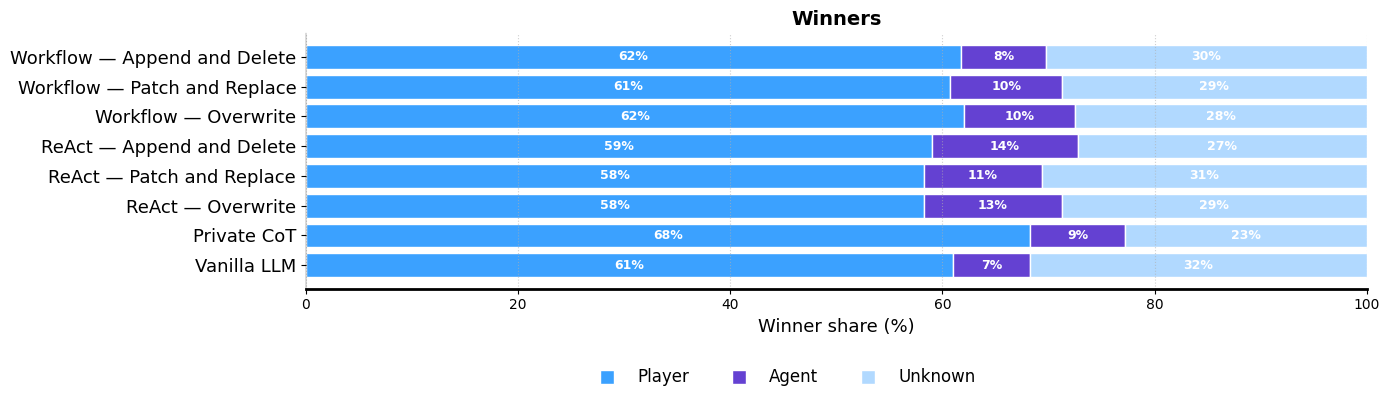

In [38]:
# === Cell: Behavioral "Winner" — pooled horizontal stacked percentages (styled) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def _winner_labelize(s):
    return str(s).replace("_", " ").title()

def plot_winner_stacked_percent(evals: pd.DataFrame):
    # Pool across everything: keep only behavioral / winner rows
    df_win = evals[(evals["mode"] == "behavioral") & (evals["metric"] == "winner")].copy()
    if df_win.empty:
        print("No winner data to plot.")
        return

    # Counts → proportions per agent
    counts = (df_win.groupby(["agent", "score"])
                    .size()
                    .unstack(fill_value=0))

    # Stable agent order from your mapping (and keep only present agents)
    agent_order = [a for a in _AGENT_MAP if a in counts.index]
    counts = counts.reindex(agent_order, fill_value=0)

    # Convert to % (rows sum to 100)
    row_sums = counts.sum(axis=1).replace(0, np.nan)
    props = (counts.div(row_sums, axis=0) * 100).fillna(0.0)

    # Pretty winner column order & color palette
    winner_cols = ["Player", "Agent", "Unknown"]  # fixed order
    for c in winner_cols:
        if c not in props.columns:
            props[c] = 0.0
    props = props[winner_cols]

    win_palette = {
        "Player":  PALETTE_LIST[2],
        "Agent":   PALETTE_LIST[4],
        "Unknown": PALETTE_LIST[0],
    }

    # Y labels: "Family — Strategy" for non-baseline, just "Family" for baseline
    ylabels = [
        (f'{_parse_family_strategy(a)[0]} — {_parse_family_strategy(a)[1]}'
         if _parse_family_strategy(a)[1] != 'Baseline' else _parse_family_strategy(a)[0])
        for a in props.index
    ]
    y_pos = np.arange(len(ylabels))

    # --- Plot ---
    fig, ax = plt.subplots(figsize=(14, 4))

    left = np.zeros(len(props), dtype=float)
    for w in winner_cols:
        ax.barh(
            y_pos, props[w].values, left=left,
            label=w, color=win_palette[w], edgecolor="white", height=0.8
        )
        left += props[w].values

    # Style & labels (match your forest styling)
    ax.set_yticks(y_pos, labels=ylabels, fontsize=13)
    ax.set_xlabel("Winner share (%)", fontsize=13)
    ax.set_xlim(0, 100)
    ax.grid(True, axis="x", linestyle=":", alpha=0.6)
    ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_linewidth(2)
    ax.spines["left"].set_linewidth(0.2)
    ax.set_title("Winners", fontweight="bold", fontsize=14)

    # Optional: show percentage labels inside large segments
    for rect in ax.patches:
        w = rect.get_width()
        # if w >= 8:  # show only if ≥8% to avoid clutter
        ax.text(
            rect.get_x() + rect.get_width()/2.0,
            rect.get_y() + rect.get_height()/2.0,
            f"{w:.0f}%",
            fontsize=9, ha="center", va="center",
            color="white", weight="bold"
        )

    # Single legend at bottom center for winner classes
    leg_handles = [
        plt.Line2D([0],[0], marker='s', color='none', markerfacecolor=win_palette[w],
                   markeredgecolor="white", markersize=10, label=w)
        for w in winner_cols
    ]
    fig.legend(
        handles=leg_handles,
        labels=winner_cols,
        loc=(0.42, 0.0), ncol=len(winner_cols),
        frameon=False, fontsize=12
    )

    fig.tight_layout(rect=[0,0.08,1,0.97])  # leave space for bottom legend
    # Extra horizontal padding if needed:
    # fig.subplots_adjust(left=0.12, right=0.95)
    plt.show()

# ---- Call ----
plot_winner_stacked_percent(evaluations)